___
---
# Zindi New User Engagement Prediction Challenge
## Time-series Binary Classification using Light Gradient Boosting


---
#### Author: Siwar Nasri

#### November 2022

---

### https://zindi.africa/competitions/zindi-new-user-engagement-prediction-challenge

## IMPORTS

In [251]:
# Standard
import os
import gc
import re
import pandas as pd
import numpy as np
import random
import time
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('darkgrid')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from numpy.random import seed
import scipy as sc

from tqdm import tqdm 
from joblib import parallel_backend, Parallel, delayed

# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from skmultilearn.problem_transform import BinaryRelevance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score

# Saving
import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 150)

def set_seed(seeed):
    seed(seeed)
    os.environ['PYTHONHASHSEED'] = str(seeed)
    np.random.seed(seeed)
    random.seed(seeed)
    
set_seed(42)

import math

In [252]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    columns = list(df.columns)

    for col in columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# EXPLORATORY DATA ANALYSIS
### THE DATA

In [253]:
root = '../input/engagement-prediction/'

info = pd.read_csv(root+'VariableDefinitions.csv').drop_duplicates()
sub = pd.read_csv(root+'SampleSubmission.csv').drop_duplicates()

In [254]:
discussions = pd.read_csv(root+'Discussion.csv').drop_duplicates()
submissions = pd.read_csv(root+'UserActivity.csv').drop_duplicates()
cp = pd.read_csv(root+'CompetitionPartipation.csv').drop_duplicates()
comments = pd.read_csv(root+'Comments.csv').drop_duplicates()
comps = pd.read_csv(root+'Competition.csv').drop_duplicates()
users = pd.read_csv(root+'Users.csv').drop_duplicates()

blog = pd.read_csv(root+'Blogs.csv').drop_duplicates()
job = pd.read_csv(root+'Jobs.csv').drop_duplicates()

In [255]:
# train = pd.read_csv(root+'Train.csv').drop_duplicates()
# test = pd.read_csv(root+'Test.csv').drop_duplicates()

# train = pd.DataFrame(columns=["User_ID", "month", "year", "day", "CompPart", "Comment", "Sub", "Disc", "Target"])
# test = pd.DataFrame(columns=["User_ID", "month", "year", "day", "CompPart", "Comment", "Sub", "Disc"])

train = pd.DataFrame(columns=["User_ID", "month", "year", "day"])
test = pd.DataFrame(columns=["User_ID", "month", "year", "day"])

### Train

train.rename(columns={'User_ID':'UserID'}, inplace=True)
display(train.head(), train.shape)

### Test

test.rename(columns={'User_ID':'UserID'}, inplace=True)
display(test.head(), test.shape)

#### For each user in the test dataset we need to predict whether they will be active on the Zindi platform during month 1,2, and 3 after the train dataset timeline. The month and year columns are in chronological order.

#### An active user is one that enters a competition, makes a submission, or engages through the discussion forums

train[train['UserID']=='ID_HF9PSCY3'].sort_values(['year','month'])

test[test['UserID']=='ID_HF9PSCY3'].sort_values(['year','month'])

#### The majority of users in testset need probabilities for being active in all 3 months, with only a few needing predictions for 1 or 2 months.

test_vc = test['UserID'].value_counts().value_counts().to_frame()
test_vc = test_vc.reset_index()
test_vc.columns = ['Number of Months to Predict', 'Count Users']
test_vc.set_index('Number of Months to Predict', inplace=True)
ax = test_vc[['Count Users']].plot(kind='pie', legend=True, subplots=True)

---
#### The submission format:

In [256]:
display(sub.head(), sub.shape)

,User_ID_Next_month_Activity,Active
0,ID_4TOXNBGB_Month_5,0
1,ID_CHFTIP26_Month_5,0
2,ID_FU5GMWLQ_Month_5,0
3,ID_254TVBQP_Month_5,0
4,ID_4ENO2VFE_Month_5,0


(1340, 2)

# PREPROCESSING

#### We are provided with several datasets which can help us in finding out "how" active a user was in a particular month. First we need to clean these tables and then through the use of appropriate and intuitive feature engineering we can create features to help in predicting whether a user will be active in the next month.

In [257]:
info = info[~info['VariableDefinition'].isna()]
display(info.head())

,VariableName,VariableDefinition
1,UserID,This is the unique ID of the user who made the comment
2,CommentDate Year,The year the comment was made in. Years are in chronological order
3,CommentDate Month,The month of the year the comment was made in. Months are in chronological order but January is not neccesarily month 1.
4,CommentDate Day_of_week,The day of the week the comment was made on. Days are in chronological order but Monday is not neccesarily day 1.
7,Country,Country competition host is from or where hackathon is being hosted. This field is masked in the same way Country is masked in the User table.


In [258]:
k = 0
for i in info['VariableDefinition'].values:
    if 'merge' in i:
        print(info.iloc[k]['VariableName'],':',i)
    k+=1

DiscID : The unique ID for each discussion, the comments table can be merged on this feature
UserID : The user who created the discussion, this can be merged with the User table on UserID
CompID : This is the ID of the competition or hackathon, this can be used to merge with the Competition Table
UserID : Unique user ID, this feature can be used to merge onto the discussion, comments and submission table


In [259]:
display(print('DISCUSSIONS'),discussions.head(1), discussions.shape) #1
display(print('COMMENTS'), comments.head(1), comments.shape)         #1
display(print('USERS'), users.head(1), users.shape)                  #1
display(print('COMPETITION PARTICIPATION'), cp.head(1), cp.shape)    #2
display(print('COMPETITIONS'), comps.head(1), comps.shape)           #2
display(print('SUBMISSIONS'), submissions.head(1), submissions.shape)#3
display(print('BLOGS'), blog.head(1), blog.shape)                    #1
display(print('JOBS'), job.head(1), job.shape)                       #1

DISCUSSIONS


None

,Competition ID,Personal,Theme,Disc_ID,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,GeneralDiscussion,1,NaN,ID_0BK7TH,ID_AAGFVLHH,19:48:26.862175,1,12,27


(1439, 9)

COMMENTS


None

,Disc_ID,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,ID_ONQEAR,ID_CEDNKSVV,16:18:44.841697,1,5,11


(467, 6)

USERS


None

,FeatureX,FeatureY,User_ID,Countries_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,0,0,ID_DC6S4E9O,X9GR,19:33:13.663391,1,1,16


(12413, 8)

COMPETITION PARTICIPATION


None

,Competition ID,Participant Type,Successful Submission Count,User_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month
0,ID_WPP3,1,NaN,ID_40G01FGV,19:38:04.689865,1,11,20


(8385, 8)

COMPETITIONS


None

,FeatureA,FeatureB,FeatureC,FeatureD,FeatureE,SecretCode,FeatureF,FeatureG,FeatureH,FeatureI,Country_ID,Comp_ID,End Time time,End Time Year,End Time Month,End Time Day_of_month,Start Time time,Start Time Year,Start Time Month,Start Time Day_of_month
0,"[2, 4]",[14],15.0,0,2,1,[3],[],[],NaN,G3F0,ID_AU0T,21:05:00,2.0,6.0,19.0,07:00:00,2,6,19


(247, 20)

SUBMISSIONS


None

,User_ID,Title,datetime time,datetime Year,datetime Month,datetime Day_of_month
0,ID_RT43AK77,comp_ID_IV5D,22:00:38,1,11,22


(317292, 6)

BLOGS


None

,Theme,blog_ID,Published At time,Published At Year,Published At Month,Published At Day_of_month
0,5.0,ID_Z6MM,10:34:55.071854,5,4,5


(117, 6)

JOBS


None

,Remote,Experience,Industry,Employment Type,Company Size,Data Science Functions,job_ID
0,NaN,2-5,"{Government,Health,""Financial Services""}",fulltime,50-200,"{""Data modelling"",""Business/Data Analysis""}",ID_VJ43


(34, 7)

In [260]:
for i in comps['End Time Month'].unique():
    
    if math.isnan(i):
        print(i)

nan


In [261]:
def changing_month(month_list):
    
    from_zindi_months = {1:6,2:7,3:8,4:9,5:10,6:11,7:12,8:1,9:2,10:3,11:4,12:5}
     
    months_list = [from_zindi_months[m] if not math.isnan(m) else np.nan for m in month_list]
    
    return months_list

np.unique(changing_month(comps['End Time Month']))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [262]:
# CHANGING MONTHS NOTATION

discussions['Created At Month'] = changing_month(discussions['Created At Month'])

comments['Created At Month'] = changing_month(comments['Created At Month'])

users['Created At Month'] = changing_month(users['Created At Month'])

cp['Created At Month'] = changing_month(cp['Created At Month'])

comps['End Time Month'] = changing_month(comps['End Time Month'])
comps['Start Time Month'] = changing_month(comps['Start Time Month'])

submissions['datetime Month'] = changing_month(submissions['datetime Month'])

blog['Published At Month'] = changing_month(blog['Published At Month'])


# # CHANGING YEARS NOTATION
# discussions['Created At Year'][discussions['Created At Month']>3]+=1

# comments['Created At Year'][comments['Created At Month']>3]+=1

# users['Created At Year'][users['Created At Month']>3]+=1

# cp['Created At Year'][cp['Created At Month']>3]+=1

# comps['Start Time Year'][comps['Start Time Month']>3]+=1
# comps['End Time Year'][comps['End Time Month']>3]+=1

# submissions['datetime Year'][submissions['datetime Month']>3]+=1

# blog['Published At Year'][blog['Published At Month']>3]+=1

In [263]:
def max_month(list_months):
    
    list_months = list_months.fillna(0).unique()
    
    return list_months.max()

def min_month(list_months):
    
    list_months = list_months.fillna(12).unique()
    
    return list_months.min()

def max_year(list_years):
    
    list_years = list_years.fillna(0).unique()
    
    return list_years.max()

def min_year(list_years):
    
    list_years = list_years.fillna(2290).unique()
    
    return list_years.min()

def max_day(list_months):
    
    month_days = {1:31,2:29,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    
    return [month_days[month] for month in list_months]
 
max_day([2,3])

[29, 31]

In [264]:
# FILLING NaN TIME_DAY, TIME_MONTH AND TIME_YEAR 

# FILLING NaN YEARS MISSING VALUES 
discussions['Created At Year'] = discussions['Created At Year'].fillna(min_year(discussions['Created At Year']))

comments['Created At Year'] = comments['Created At Year'].fillna(min_year(comments['Created At Year']))

users['Created At Year'] = users['Created At Year'].fillna(min_year(users['Created At Year']))

cp['Created At Year'] = cp['Created At Year'].fillna(min_year(cp['Created At Year']))

comps['Start Time Year'] = comps['Start Time Year'].fillna(min_year(comps['Start Time Year']))
comps['End Time Year'] = comps['End Time Year'].fillna(max_year(comps['End Time Year']))

submissions['datetime Year'] = submissions['datetime Year'] .fillna(min_year(submissions['datetime Year']))

blog['Published At Year'] = blog['Published At Year'].fillna(min_year(blog['Published At Year']))

# FILLING NaN MONTHS MISSING VALUES

discussions['Created At Month'] = discussions['Created At Month'].fillna(min_month(discussions['Created At Month']))

comments['Created At Month'] = comments['Created At Month'].fillna(min_month(comments['Created At Month']))

users['Created At Month'] = users['Created At Month'].fillna(min_month(users['Created At Month']))

cp['Created At Month'] = cp['Created At Month'].fillna(min_month(cp['Created At Month']))

comps['Start Time Month'] = comps['Start Time Month'].fillna(min_month(comps['Start Time Month']))
comps['End Time Month'] = comps['End Time Month'].fillna(max_month(comps['End Time Month']))

submissions['datetime Month'] = submissions['datetime Month'] .fillna(min_month(submissions['datetime Month']))

blog['Published At Month'] = blog['Published At Month'].fillna(min_month(blog['Published At Month']))



# FILLING NaN DAYS MISSING VALUES 

discussions['Created At Day_of_month'] = discussions['Created At Day_of_month'].fillna(1)

comments['Created At Day_of_month'] = comments['Created At Day_of_month'].fillna(1)

users['Created At Day_of_month'] = users['Created At Day_of_month'].fillna(1)

cp['Created At Day_of_month'] = cp['Created At Day_of_month'].fillna(1)

comps['Start Time Day_of_month'] = comps['Start Time Day_of_month'].fillna(1)
max_days_by_mon = max_day(comps['End Time Month'])
comps['End Time Day_of_month'] = [m if not math.isnan(m) else max_days_by_mon[i] for i, m in enumerate(comps['End Time Day_of_month'])]

submissions['datetime Day_of_month'] = submissions['datetime Day_of_month'].fillna(1)

blog['Published At Day_of_month'] = blog['Published At Day_of_month'].fillna(1)

In [265]:
# CLEAN THE COLUMN NAMES
discussions.columns = discussions.columns.str.replace(' ', '_')
comments.columns = comments.columns.str.replace(' ', '_')
users.columns = users.columns.str.replace(' ', '_')
cp.columns = cp.columns.str.replace(' ', '_')
comps.columns = comps.columns.str.replace(' ', '_')
submissions.columns = submissions.columns.str.replace(' ', '_')
blog.columns = blog.columns.str.replace(' ', '_')
job.columns = job.columns.str.replace(' ', '_')

# DROP UNNAICESSARY COLUMNS 
discussions = discussions.drop(['Created_At_time'], 1)
submissions = submissions.drop(['datetime_time'], 1)
cp = cp.drop(['Created_At_time'], 1)
comments = comments.drop(['Created_At_time'], 1)
comps = comps.drop(['Start_Time_time', 'End_Time_time'], 1)
users = users.drop(['Created_At_time'], 1)
blog = blog.drop(['Published_At_time'], 1)

# 1 HOT ENCODE CATORGORICAL COLUMNS FROM USER AND COMPS DF
users = pd.get_dummies(users, columns=['FeatureY'], drop_first=False)
comps = pd.get_dummies(comps, columns=['FeatureE', 'FeatureC'], drop_first=False)

# CLEAN COMPETITION PARTICIPATION COLUMNS AND 1 HOT ENCODE
cp = cp.drop(columns="Participant_Type")
cp['Successful_Submission_Count'] = cp['Successful_Submission_Count'].str.replace('count ', '')
cp['Sub'] = pd.isna(cp["Successful_Submission_Count"]).replace({True:False, False:True})*1
cp = pd.get_dummies(cp, columns = ['Successful_Submission_Count'], drop_first=False) 

# SOME COMPS ARE NEVER ENDING
########## comps['CompEndTime_Year'] = comps['CompEndTime_Year'].replace('not mapped', np.NaN).astype('float32')

# THE DATA IN FEATURE COLUMNS IN OUR COMPS TABLE ARE IN LISTS, INDICATING WHICH CATORGORIES THE COMP FALLS INTO
## LETS CREATE SOME NEW FEATURES FROM EACH FEATURE COLUMNS VALUES IN THE LISTS
# FIRST REMOVE LIST BRACKETS SO WE ARE LEFT WITH COMMA SEPARATED VALUES
comps['FeatureA'] =  comps['FeatureA'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureB'] =  comps['FeatureB'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureF'] =  comps['FeatureF'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureG'] =  comps['FeatureG'].apply(lambda x:re.sub(r'\[|\]', '', x))
comps['FeatureH'] =  comps['FeatureH'].apply(lambda x:re.sub(r'\[|\]', '', x))

# CREATE DATAFRAME OF COLUMNS INDICATING WHETHER A VALUE IS PRESENT IN THE FEATURE COLUMN FOR EACH COMPID
feature_A = comps.set_index('Comp_ID').FeatureA.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_B = comps.set_index('Comp_ID').FeatureB.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_F = comps.set_index('Comp_ID').FeatureF.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_G = comps.set_index('Comp_ID').FeatureG.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)
feature_H = comps.set_index('Comp_ID').FeatureH.str.split(', ') \
            .apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True)

# RENAME THE COLUMNS OF CREATED DATAFRAMES
for col in feature_A.columns:
    feature_A.rename(columns={col:'feature_A_'+col}, inplace=True)
for col in feature_B.columns:
    feature_B.rename(columns={col:'feature_B_'+col}, inplace=True)
for col in feature_F.columns:
    feature_F.rename(columns={col:'feature_F_'+col}, inplace=True)
for col in feature_G.columns:
    feature_G.rename(columns={col:'feature_G_'+col}, inplace=True)
for col in feature_H.columns:
    feature_H.rename(columns={col:'feature_H_'+col}, inplace=True)

# CONCAT THE CLEAN DATAFRAMES ON COMPS TABLE AND DROP THE ORIGINAL FEATURE
comps = pd.concat([comps, feature_A, feature_B, feature_F, feature_G, feature_H], axis=1).drop(['FeatureA', 'FeatureB', 'FeatureF', 'FeatureG', 'FeatureH'],1)

### ALL THE DATASETS

In [266]:
display(print('DISCUSSIONS'),discussions.head(1), discussions.shape) #1
display(print('COMMENTS'), comments.head(1), comments.shape)         #1
display(print('USERS'), users.head(1), users.shape)                  #1
display(print('COMPETITION PARTICIPATION'), cp.head(1), cp.shape)    #2
display(print('COMPETITIONS'), comps.head(1), comps.shape)           #2
display(print('SUBMISSIONS'), submissions.head(1), submissions.shape)#3
display(print('BLOGS'),blog.head(1), blog.shape)                     #1
display(print('JOBS'), job.head(1), job.shape)                       #1

DISCUSSIONS


None

,Competition_ID,Personal,Theme,Disc_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
0,GeneralDiscussion,1,NaN,ID_0BK7TH,ID_AAGFVLHH,1,5,27


(1439, 8)

COMMENTS


None

,Disc_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month
0,ID_ONQEAR,ID_CEDNKSVV,1,10,11


(467, 5)

USERS


None

,FeatureX,User_ID,Countries_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,FeatureY_0,FeatureY_1,FeatureY_3
0,0,ID_DC6S4E9O,X9GR,1,6,16,1,0,0


(12413, 9)

COMPETITION PARTICIPATION


None

,Competition_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9
0,ID_WPP3,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0


(8385, 14)

COMPETITIONS


None

,FeatureD,SecretCode,FeatureI,Country_ID,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,FeatureE_1,FeatureE_2,FeatureE_3,FeatureC_1.0,FeatureC_2.0,FeatureC_3.0,FeatureC_4.0,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11
0,0,1,NaN,G3F0,ID_AU0T,2.0,11.0,19.0,2,11,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


(247, 106)

SUBMISSIONS


None

,User_ID,Title,datetime_Year,datetime_Month,datetime_Day_of_month
0,ID_RT43AK77,comp_ID_IV5D,1,4,22


(317292, 5)

BLOGS


None

,Theme,blog_ID,Published_At_Year,Published_At_Month,Published_At_Day_of_month
0,5.0,ID_Z6MM,5,9,5


(117, 5)

JOBS


None

,Remote,Experience,Industry,Employment_Type,Company_Size,Data_Science_Functions,job_ID
0,NaN,2-5,"{Government,Health,""Financial Services""}",fulltime,50-200,"{""Data modelling"",""Business/Data Analysis""}",ID_VJ43


(34, 7)

#### If a UserID is present in the DISCUSSIONS, COMMENTS, COMPETITION PARTICIPATION, or SUBMISSIONS table in a particular month, then the Target in that particular month should be 1 for the UserID in the train df.

In [267]:
def fix_incorrect_target_labels(train):

    check1 = train[train['Comment']==1]['User_ID'].unique()
    print(len(check1))
    check2 = comments[comments['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    
    # TO BE CORRECTED USERIDS FOR COMMENTS TABLE
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    for userid in tbc:
        train.loc[train['User_ID']==userid, 'Comment'] = 0

    check1 = train[train['Comment']==1]['User_ID'].unique()
    print(len(check1))
    check2 = comments[comments['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    
    # SHOULD BE CORRECTED NOW: LETS CHECK
    tbc = list(set(check1) - set(check2))
    print(len(tbc))
    
    check1 = train[train['CompPart']==1]['User_ID'].unique()
    print(len(check1))
    check2 = cp[cp['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    for userid in tbc:
        train.loc[train['User_ID']==userid, 'CompPart'] = 0

    check1 = train[train['CompPart']==1]['User_ID'].unique()
    print(len(check1))
    check2 = cp[cp['User_ID'].isin(check1)]['User_ID'].unique()
    print(len(check2))
    tbc = list(set(check1) - set(check2))
    print(len(tbc))

    train['Target'] = train['CompPart'] + train['Comment'] + train['Sub'] + train['Disc']
    train.loc[train['Target']>0, 'Target'] = 1
    return train

##########################" train = fix_incorrect_target_labels(train)

---
---
# FEATURE ENGINEERING

### Using Discussion data and Blog data

In [268]:
############################ to be changet #####################################




# comps_["Disc"] = pd.isna(discussions["Disc"]).replace({True:False, False:True})*1




# comps_["Blog"] = pd.isna(blog["Blog"]).replace({True:False, False:True})*1




############################ to be changet #####################################

### Using Competition Participation data and Competition data

In [269]:
cp = cp.rename(columns={"Competition_ID":"Comp_ID"})

In [270]:
user_comps = cp.merge(comps, on='Comp_ID', how='left')
display(user_comps.head(), user_comps.shape) 

,Comp_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9,FeatureD,SecretCode,FeatureI,Country_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,FeatureE_1,FeatureE_2,FeatureE_3,FeatureC_1.0,FeatureC_2.0,FeatureC_3.0,FeatureC_4.0,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11
0,ID_WPP3,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,3.0,2.0,24.0,4,11,25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,ID_ZN92,ID_40G01FGV,1,4,20,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,1.0,5.0,1.0,1,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,ID_I9BN,ID_40G01FGV,1,5,17,0,0,0,0,0,0,0,0,0,1,0,10.0,03GB,1.0,8.0,14.0,1,5,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
3,ID_PDKH,ID_40G01FGV,1,5,6,1,1,0,0,0,0,0,0,0,1,0,10.0,G3F0,1.0,7.0,23.0,1,4,14,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
4,ID_CFN7,ID_P33ABQX5,1,10,26,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,2023.0,2.0,12.0,1,10,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


(8385, 119)

In [271]:
# CREATE EMPTY DATAFRAME TO STORE AGGREGATIONS
user_comps_agg = pd.DataFrame()
# CREATE GROUBY OBJECT FOR THE MONTH AND YEAR THE A USER PARTICIPATED IN A COMP
uc_groupby = user_comps.groupby(['User_ID','Comp_ID', 'Created_At_Year', 'Created_At_Month','Sub', 'Created_At_Day_of_month'])

In [272]:
for col in user_comps.columns:
    for i in ['FeatureI',  'SecretCode', 'FeatureD']:
        if i in col:
            # SUM ALL THESE FEATURES FOR A USER BY MONTH YEAR AND ADD TO AGG DF
            user_comps_agg[col + '_sum'] = uc_groupby.agg({col:np.sum})

In [273]:
# FIND OUT HOW MANY COMPS A USER JOINED DURING EACH MONTH
user_comps_agg['count_comps'] = uc_groupby.agg({'User_ID':pd.Series.count})
user_comps_agg = user_comps_agg.reset_index()
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN COLUMNS
user_comps_agg.rename(columns={'Created_At_Month':'month', 'Created_At_Year':'year', 'Created_At_Day_of_month':'day'}, inplace=True)
user_comps_agg.set_index(['User_ID', 'month', 'year', 'day'], inplace=True)
display(user_comps_agg.head(), user_comps_agg.shape)

Comp_ID  Sub  FeatureD_sum  SecretCode_sum  \
User_ID     month year day                                               
ID_011YM9VH 8     1    9    ID_F7QD    0             1               0   
            7     1    27   ID_GAV9    0             0               0   
ID_015M2NE1 5     1    27   ID_8SHD    0             1               0   
ID_01BEG5HQ 8     1    22   ID_KU2G    0             1               0   
                       23   ID_PJZC    0             1               0   

                            FeatureI_sum  count_comps  
User_ID     month year day                             
ID_011YM9VH 8     1    9             2.0            1  
            7     1    27            2.0            1  
ID_015M2NE1 5     1    27            2.0            1  
ID_01BEG5HQ 8     1    22            4.0            1  
                       23            7.0            1

(8385, 6)

---
### Using Submissions data

In [274]:
display(submissions)

,User_ID,Title,datetime_Year,datetime_Month,datetime_Day_of_month
0,ID_RT43AK77,comp_ID_IV5D,1,4,22
1,ID_RT43AK77,comp_ID_IV5D,1,4,23
2,ID_RT43AK77,comp_ID_IV5D,1,4,23
3,ID_RT43AK77,comp_ID_IV5D,1,4,23
4,ID_RT43AK77,comp_ID_IV5D,1,4,23
...,...,...,...,...,...
317287,ID_Z759BCS3,job_ID_5ONI,1,4,14
317288,ID_WNJMADF8,job_ID_5ONI,1,4,14
317289,ID_7NBY9MV2,job_ID_5ONI,1,4,20
317290,ID_LHPJJSOK,job_ID_5ONI,1,4,14


#### Using the submissions data we can create a feature that represents how frequently a user makes submissions per month per comp by considering the difference in time between submission days of the week.

In [275]:
def diff(df):
    """
    Function to calculate circular difference between two days of the week where each day is
    consecutive and labeled from 1 - 7.
    
    eg. The mathematical difference between 7 and 1 is 6 but the the circular difference 
        between day 7 and day 1 is 1. 
    
    input:   df[['day of week', 'day of week shitfed']]
    returns: series with circular differenece along axis 1.
    """
    min_ = df.min(axis=1).reset_index(drop=True)
    max_ = df.max(axis=1).reset_index(drop=True)
    diff = max_ - min_
    d = diff.where(diff<=4, abs(6 - max_))
    return d.reset_index(drop=True)

In [276]:
"""%%time
# SORT SUBMISSIONS
submissions = submissions.sort_values(['datetime_Year', 'datetime_Month', 'datetime_Day_of_month'])

# APPLY DIFF FUNCTION
groups = []
for [uid, cid, y, m], df in tqdm(submissions.groupby(['User_ID', 'Title', 'datetime_Year','datetime_Month'])):
    df.reset_index(drop=True, inplace=True)
    df['SubDate_Day_of_month_shift'] = df['datetime_Day_of_month'].shift()
    df['sub_time_diff'] = diff(df[['datetime_Day_of_month','SubDate_Day_of_month_shift']])
    groups.append(df)
    
submissions_df = pd.concat(groups, axis=0)

submissions_df.drop(['SubDate_Day_of_month_shift'],1,inplace=True)
submissions = submissions_df.copy()
del submissions_df
gc.collect()"""
##################################################################################
####################################

"%%time\n# SORT SUBMISSIONS\nsubmissions = submissions.sort_values(['datetime_Year', 'datetime_Month', 'datetime_Day_of_month'])\n\n# APPLY DIFF FUNCTION\ngroups = []\nfor [uid, cid, y, m], df in tqdm(submissions.groupby(['User_ID', 'Title', 'datetime_Year','datetime_Month'])):\n    df.reset_index(drop=True, inplace=True)\n    df['SubDate_Day_of_month_shift'] = df['datetime_Day_of_month'].shift()\n    df['sub_time_diff'] = diff(df[['datetime_Day_of_month','SubDate_Day_of_month_shift']])\n    groups.append(df)\n    \nsubmissions_df = pd.concat(groups, axis=0)\n\nsubmissions_df.drop(['SubDate_Day_of_month_shift'],1,inplace=True)\nsubmissions = submissions_df.copy()\ndel submissions_df\ngc.collect()"

In [277]:
# CREATE EMPTY DATARFRAME TO STORE AGGREGATED DATA
submissions_agg = pd.DataFrame()
# CREATE GROUBY OBJECT FOR THE MONTH AND YEAR A USER SUMMITED TO A COMP
subs_groupby = submissions.groupby(['User_ID', 'Title', 'datetime_Year','datetime_Month', 'datetime_Day_of_month'])
            
for col in submissions.columns:
    for i in ['sub_time_diff']: #['datetime_Day_of_month', 'FeatureG', 'sub_time_diff']:
        if i in col:
            # MEAN VALUES FOR COLUMNS PER COMP IN A MONTH
            submissions_agg[col + '_mean'] = subs_groupby.agg({col:np.mean})

# NUMBER OF SUBS TO COMP IN A MONTH PER USER
submissions_agg['count_subs'] = subs_groupby.agg({'User_ID':pd.Series.count})

submissions_agg = submissions_agg.reset_index()

# NUMBER OF COMPS A USER MADE SUBMISSIONS TO
submissions_agg['count_comps_sub'] = submissions_agg.groupby(['User_ID', 
                                                              'datetime_Year',
                                                              'datetime_Month',
                                                              'datetime_Day_of_month'])['User_ID'].transform('count')
# TOTAL NUMBER OF SUBS MADE TO COMPS IN A MONTH
submissions_agg['count_subs'] = submissions_agg.groupby(['User_ID', 
                                                         'datetime_Year',
                                                         'datetime_Month',
                                                         'datetime_Day_of_month'])['count_subs'].transform('sum')

In [278]:
submissions_agg["sub_time_diff_mean"]=1 ########### suprimer

In [279]:
# MEAN VALUES FOR COLUMNS IN A MONTH (COMBINE INFO FROM COMPS SUBBED TO)
for col in ['sub_time_diff_mean']: #['datetime_Day_of_month_mean', 'sub_time_diff_mean']:
  
    submissions_agg[col] = submissions_agg.groupby(['User_ID', 
                                                    'datetime_Year',
                                                    'datetime_Month',
                                                    'datetime_Day_of_month'])[col].transform('mean')

# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
submissions_agg.rename(columns={'datetime_Month':'month', 'datetime_Year':'year', 'datetime_Day_of_month':'day'}, inplace=True)

In [280]:
# DROP COMPID AS IT IS NO LONGER REQUIRED
##### submissions_agg = submissions_agg.drop(['Comp_ID'],1).drop_duplicates().set_index(['User_ID', 'month', 'year'])
        
submissions_agg = submissions_agg.drop_duplicates()
submissions_agg['Active'] = 1
submissions_agg = submissions_agg.set_index(['User_ID', 'month', 'year','day'])

display(submissions_agg)

Title  count_subs  \
User_ID     month year day                                          
ID_000H9XOP 10    1    22               $create_alias           5   
                       22                   $identify           5   
                       22                   Signed Up           5   
                       22     Viewed All Competitions           5   
                       22      Viewed All Discussions           5   
...                                               ...         ...   
ID_ZZVUJ45W 8     1    5                    Signed Up          13   
                       5      Viewed All Competitions          13   
                       5       Viewed All Discussions          13   
                       5    Viewed All Learning Pages          13   
                       5                   badge_OCZE          13   

                            count_comps_sub  sub_time_diff_mean  Active  
User_ID     month year day                                               
ID_000H9XOP 10    1    22                 5                 1.0       1  
                       22                 5                 1.0       1  
                       22                 5                 1.0       1  
                       22                 5                 1.0       1  
                       22                 5                 1.0       1  
...                                     ...                 ...     ...  
ID_ZZVUJ45W 8     1    5                 10                 1.0       1  
                       5                 10                 1.0       1  
                       5                 10                 1.0       1  
                       5                 10                 1.0       1  
                       5                 10                 1.0       1  

[159252 rows x 5 columns]

---

In [281]:
"""train = pd.read_csv(root+'Train.csv').drop_duplicates()
train.rename(columns={'User_ID':'UserID'}, inplace=True)"""

################################ train = fix_incorrect_target_labels(train)

train = train.set_index(['User_ID', 'month', 'year','day'])
print(train.shape)

(0, 0)


### MERGE AGGREGATED DATA FROM SUBMISSIONS AND COMPETITION PARTICIPATION TABLES ONTO TRAIN DF

In [282]:
train

,,,
User_ID,month,year,day


In [283]:
user_comps_agg.sample()

,,,,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps
User_ID,month,year,day,,,,,,
ID_CENPB38W,5,1,23,ID_I9BN,0,1,0,10.0,1


In [284]:
submissions_agg.sample()

,,,,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active
User_ID,month,year,day,,,,,
ID_26RE2MSM,7,1,25,comp_ID_1CTF,8,5,1.0,1


In [285]:
train = train.merge(submissions_agg, left_index=True, right_index=True, how='outer') #how='left'
train = train.merge(user_comps_agg, left_index=True, right_index=True, how='outer') #how='left'

train = train.reset_index()
train = train.sort_values(['year','month', 'day'])

print('\n\n NEW TRAIN DATAFRAME: \n')
display(train)



 NEW TRAIN DATAFRAME: 



,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps
1645,ID_0B7198UX,4,1,1,$create_alias,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1646,ID_0B7198UX,4,1,1,$identify,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2796,ID_0JQTGLPB,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_CR6P,0.0,1.0,0.0,1.0,1.0
3074,ID_0LEMS0F7,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_E1KX,0.0,1.0,0.0,2.0,1.0
4832,ID_0W3L4Z8R,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_9BU8,0.0,1.0,0.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176351,ID_ZYK49EEF,10,1,27,Viewed All Competitions,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
176352,ID_ZYK49EEF,10,1,27,Viewed All Discussions,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
176353,ID_ZYK49EEF,10,1,27,Viewed All Learning Pages,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
176354,ID_ZYK49EEF,10,1,27,badge_OCZE,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


---
### Using Comments data

In [286]:
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
comments.rename(columns={'Created_At_Year': 'year', 
                         'Created_At_Month': 'month',
                         'Created_At_Day_of_month': 'day'}, inplace=True)

In [287]:
# FIND NUMBER OF COMMENTS MADE BY USERS IN A MONTH
comments['count_comments'] = comments.groupby(['User_ID', 'year', 'month', 'day'])['User_ID'].transform('count')
# GET THE MEAN DAY OF WEEK EACH USER MADE A COMMENT ON
"""comments['CommentDate_Day_of_month'] = comments.groupby(['User_ID', 'year', 'month'])['Created_At_Day_of_month'].\
                                                                                     transform('mean')
"""
comments = comments.drop_duplicates()
display(comments)

,Disc_ID,User_ID,year,month,day,count_comments
0,ID_ONQEAR,ID_CEDNKSVV,1,10,11,1
1,ID_E0NHSS,ID_CEDNKSVV,1,5,23,1
2,ID_3XKIOF,ID_CEDNKSVV,1,6,3,1
3,ID_XCC6W4,ID_CEDNKSVV,1,6,5,1
4,ID_OIGXGK,ID_CEDNKSVV,1,5,19,1
...,...,...,...,...,...,...
462,ID_DK2VV3,ID_GPXBD1BG,1,6,14,1
463,ID_5MJRT0,ID_2F218EUV,1,6,15,1
464,ID_RMQMJA,ID_9W2RXCMI,1,6,23,1
465,ID_V5431U,ID_RQEQ74SK,1,5,29,1


In [288]:
from collections import Counter
Counter(comments.count_comments)

Counter({1: 191,
         2: 78,
         6: 11,
         3: 56,
         7: 8,
         9: 8,
         5: 24,
         4: 26,
         12: 12,
         11: 11,
         10: 7})

### MERGE AGGREGATED DATA FROM COMMENTS TABLE ONTO TRAIN DF  

In [289]:
train = train.merge(comments, on = ['User_ID', 'year', 'month', 'day'], how='left')
display(train)

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments
0,ID_0B7198UX,4,1,1,$create_alias,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_0B7198UX,4,1,1,$identify,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_0JQTGLPB,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_CR6P,0.0,1.0,0.0,1.0,1.0,NaN,NaN
3,ID_0LEMS0F7,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_E1KX,0.0,1.0,0.0,2.0,1.0,NaN,NaN
4,ID_0W3L4Z8R,4,1,1,NaN,NaN,NaN,NaN,NaN,ID_9BU8,0.0,1.0,0.0,10.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177311,ID_ZYK49EEF,10,1,27,Viewed All Competitions,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177312,ID_ZYK49EEF,10,1,27,Viewed All Discussions,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177313,ID_ZYK49EEF,10,1,27,Viewed All Learning Pages,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177314,ID_ZYK49EEF,10,1,27,badge_OCZE,8.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
train["Comment"] = pd.isna(train["count_comments"]).replace({True:False, False:True})*1

### MERGE USER INFO FROM USERS TABLE ONTO TRAIN DF

In [291]:
# RENAME COLUMNS FOR EASY MERGE WITH TRAIN DF
users.rename(columns={'Created_At_Year': 'year', 
                         'Created_At_Month': 'month',
                         'Created_At_Day_of_month': 'day'}, inplace=True)

In [292]:
train = train.merge(users, on=['User_ID','year','month','day'], how='left')
display(train.head(2))

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,Countries_ID,FeatureY_0,FeatureY_1,FeatureY_3
0,ID_0B7198UX,4,1,1,$create_alias,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,X9GR,0.0,1.0,0.0
1,ID_0B7198UX,4,1,1,$identify,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,X9GR,0.0,1.0,0.0


---

In [293]:
train[['count_subs', 'count_comps_sub', 'count_comps', 'count_comments']] = \
train[['count_subs', 'count_comps_sub', 'count_comps', 'count_comments']].fillna(0)

# 1 HOT ENCODE THE CATOROGORICAL COUNTY COLUMN
train = pd.get_dummies(train, columns=['Countries_ID'])

# SORT
train = train.sort_values(['User_ID','year','month','day'])

---
## MORE FEATURE ENGINEERING


### Getting data on the latest competition a user participated in

In [294]:
# SUBSET THE COMPETETION PARTICIPATION DATAFRAME FOR THE LAST COMP A USER JOINED PER MONTH
cp = cp.sort_values(['User_ID', 'Created_At_Year', 
                     'Created_At_Month', 
                     'Created_At_Day_of_month']).drop_duplicates(subset=
                                                                     ['User_ID', 'Created_At_Year', 
                                                                      'Created_At_Month','Created_At_Day_of_month'], keep='last')

display(cp.sample(3))

,Comp_ID,User_ID,Created_At_Year,Created_At_Month,Created_At_Day_of_month,Sub,Successful_Submission_Count_10,Successful_Submission_Count_3,Successful_Submission_Count_4,Successful_Submission_Count_5,Successful_Submission_Count_6,Successful_Submission_Count_7,Successful_Submission_Count_8,Successful_Submission_Count_9
4745,ID_53GM,ID_VYPILJKH,1,8,11,0,0,0,0,0,0,0,0,0
6961,ID_528W,ID_5VUKI05N,1,6,8,0,0,0,0,0,0,0,0,0
4155,ID_JRC2,ID_4J9Q6WXA,1,8,8,0,0,0,0,0,0,0,0,0


In [295]:
# MERGE WITH COMPS INFO TABLE
latest_cp = pd.merge(cp, comps, on='Comp_ID', how='left')
# 1 HOT ENCODE THE COMP_ID COLUMN
latest_cp = pd.get_dummies(latest_cp, columns=['Comp_ID'])

# DO VERY MINIMAL FEATURE SELECTION 
cols = ['User_ID', 'Created_At_Month', 'Created_At_Year','Created_At_Day_of_month'] + [c for c in latest_cp.columns if 'Comp' in c] + \
       [c for c in latest_cp.columns if 'Feature' in c] + [c for c in latest_cp.columns if 'feature' in c]
latest_cp = latest_cp[cols]
	
latest_cp.rename(columns={'Created_At_Month':'month', 'Created_At_Year':'year', 'Created_At_Day_of_month':'day'}, inplace=True)
display(latest_cp.head(), latest_cp.shape)

,User_ID,month,year,day,Comp_ID_ID_0D02,Comp_ID_ID_0SN1,Comp_ID_ID_0W7H,Comp_ID_ID_0Y9T,Comp_ID_ID_1261,Comp_ID_ID_1CTF,Comp_ID_ID_1DWD,Comp_ID_ID_1Q60,Comp_ID_ID_1ZWS,Comp_ID_ID_208Z,Comp_ID_ID_20XL,Comp_ID_ID_2MIC,Comp_ID_ID_3AG0,Comp_ID_ID_3MK3,Comp_ID_ID_3RMM,Comp_ID_ID_44CX,Comp_ID_ID_45W9,Comp_ID_ID_51ZG,Comp_ID_ID_528W,Comp_ID_ID_53GM,Comp_ID_ID_540G,Comp_ID_ID_56O8,Comp_ID_ID_5KD8,Comp_ID_ID_5NAE,Comp_ID_ID_61E9,Comp_ID_ID_64EM,Comp_ID_ID_66QC,Comp_ID_ID_6E1C,Comp_ID_ID_6IDY,Comp_ID_ID_7079,Comp_ID_ID_7CF2,Comp_ID_ID_7YDI,Comp_ID_ID_89DI,Comp_ID_ID_8B8I,Comp_ID_ID_8BH9,Comp_ID_ID_8DGC,Comp_ID_ID_8SHD,Comp_ID_ID_9BU8,Comp_ID_ID_9TS1,Comp_ID_ID_A1ZA,Comp_ID_ID_AL6C,Comp_ID_ID_AS79,Comp_ID_ID_BARV,Comp_ID_ID_BR9A,Comp_ID_ID_BXIL,Comp_ID_ID_BZV0,Comp_ID_ID_CFN7,Comp_ID_ID_CMWO,Comp_ID_ID_CNBR,Comp_ID_ID_CR6P,Comp_ID_ID_CVUS,Comp_ID_ID_CYEF,Comp_ID_ID_D242,Comp_ID_ID_D3SA,Comp_ID_ID_D6NX,Comp_ID_ID_DD5S,Comp_ID_ID_E1KX,Comp_ID_ID_F5JG,Comp_ID_ID_F7QD,Comp_ID_ID_FCRM,Comp_ID_ID_FM77,Comp_ID_ID_FN7K,Comp_ID_ID_FZ48,Comp_ID_ID_G05Z,Comp_ID_ID_G5IQ,Comp_ID_ID_GAV9,Comp_ID_ID_GR92,Comp_ID_ID_GVGW,Comp_ID_ID_GWL0,Comp_ID_ID_H3QQ,Comp_ID_ID_HCN1,Comp_ID_ID_HCST,Comp_ID_ID_HGJN,Comp_ID_ID_I9BN,Comp_ID_ID_IMTG,Comp_ID_ID_IQLI,Comp_ID_ID_IV5D,Comp_ID_ID_IVH9,Comp_ID_ID_J5IZ,Comp_ID_ID_J883,Comp_ID_ID_JRC2,Comp_ID_ID_JX23,Comp_ID_ID_KESL,Comp_ID_ID_KGUF,Comp_ID_ID_KHED,Comp_ID_ID_KU2G,Comp_ID_ID_L3EB,Comp_ID_ID_L9R0,Comp_ID_ID_LFJT,Comp_ID_ID_LSIO,Comp_ID_ID_M3G0,Comp_ID_ID_MN35,Comp_ID_ID_N5MO,Comp_ID_ID_NKJR,Comp_ID_ID_OAR6,Comp_ID_ID_OP12,...,Comp_ID_ID_YCUK,Comp_ID_ID_YDM3,Comp_ID_ID_ZN92,FeatureD,FeatureI,FeatureE_1,FeatureE_2,FeatureE_3,FeatureC_1.0,FeatureC_2.0,FeatureC_3.0,FeatureC_4.0,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11
0,ID_011YM9VH,7,1,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,ID_011YM9VH,8,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,ID_015M2NE1,5,1,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

(6734, 229)

#### USING MERGE ASOF TO MERGE COMP INFO WITH TRAIN BY USER ID AND DATE

In [296]:
cp[["Created_At_Month", "Created_At_Day_of_month"]].loc[cp["Created_At_Day_of_month"]==30].Created_At_Month.unique()

array([6, 7, 5, 8, 9, 4])

In [297]:
cp[["Created_At_Month", "Created_At_Day_of_month"]].loc[cp["Created_At_Month"]==7]

,Created_At_Month,Created_At_Day_of_month
3284,7,27
6152,7,25
1197,7,21
1198,7,23
1201,7,27
...,...,...
614,7,6
1211,7,23
2199,7,6
2973,7,30


In [298]:
train.year.unique()

array([1])

In [299]:
# FOR MERGING ONTO THE TRAIN DF WE WILL CREATE A DATE COLUMN BY MAPPING A MONTH AND YEAR NAME TO EACH MONTH,YEAR
"""year_dict = {1:2015,2:2016,3:2017,4:2018}
month_dict = {8:'January',9:'February',10:'March',11:'April',12:'May',1:'June', 2:'July',3:'August',4:'September', 5:'October', 6:'November', 7:'December'}
"""

year_dict = {1:2020,2:2021,3:2022,4:2023}
month_dict = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June', 7:'July',8:'August',9:'September', 10:'October', 11:'November', 12:'December'}

train['date_year'] = train['year'].map(year_dict)
train['date_month'] = train['month'].map(month_dict)

latest_cp['date_year'] = latest_cp['year'].map(year_dict)
latest_cp['date_month'] = latest_cp['month'].map(month_dict)

In [300]:
# CONVERT THE DATE COLUMN TO DATETIME

train['date'] = pd.to_datetime(train['date_year'].astype(str)  + train['date_month']  + train['day'].astype(str), format='%Y%B%d')

latest_cp['date'] = pd.to_datetime(latest_cp['date_year'].astype(str)  + latest_cp['date_month']  + train['day'].astype(str), format='%Y%B%d')
latest_cp = latest_cp.drop(['year', 'month', 'date_year', 'date_month', 'day'], 1)

# SORT BY DATE
latest_cp = latest_cp.sort_values('date')
train = train.sort_values('date')

### MERGE LATEST COMP DATA TO TRAIN DF USING pd.merge_asof

In [301]:
train = pd.merge_asof(train, latest_cp, by='User_ID', on='date')
train = train.drop(['date', 'date_year', 'date_month'],1)
train = train.sort_values(['User_ID','year','month','day'])

---
### CREATING CUMSUM FEATURES 

#### We can create cumsum features to capture the users activity over time. We will select some features from the train dataframe based on how many unique values are present in the column and create cumsum features using these columns.

In [302]:
# CREATE EMPTY DATAFRAME
nunique_df = pd.DataFrame()

# FILL THE DATAFRAME WITH NUMBER OF UNIQUE FEATURES FOR EACH COLUMN IN TRAIN DF
features = [c for c in train.columns if c not in ['User_ID', 'month', 'year','day']]
for col in features:
    nunique_df[col] = [train[col].nunique()]

nunique_df = nunique_df.T.reset_index()
nunique_df.rename(columns={0:'n_unique', 'index':'feature'}, inplace=True)
nunique_df = nunique_df.sort_values('n_unique')
display(nunique_df)

,feature,n_unique
378,feature_H_11,1
322,FeatureC_36.0,1
305,FeatureC_19.0,1
355,feature_F_4,1
307,FeatureC_21.0,1
...,...,...
2,count_comps_sub,32
11,Disc_ID,78
5,Comp_ID,131
1,count_subs,133


In [303]:
%%time
# SELECT COLUMNS
ccols = nunique_df[nunique_df['n_unique']>=18]['feature'].tolist()+['CompPart', 'Comment', 'Sub', 'Disc','Target']
"""
# CREATE CUMSUM FEATURES FROM SELECTED COLUMNS
for col in tqdm(ccols):
    train[f'{col}_cumsum'] = train.groupby('User_ID')[col].cumsum()"""

CPU times: user 1.05 ms, sys: 4 µs, total: 1.05 ms
Wall time: 1.01 ms


"\n# CREATE CUMSUM FEATURES FROM SELECTED COLUMNS\nfor col in tqdm(ccols):\n    train[f'{col}_cumsum'] = train.groupby('User_ID')[col].cumsum()"

---

#### DEALING WITH NaNs and inf VALUES BY FORWARD FILLING

In [304]:
%%time
# REPLACE INFINITE VALUES
train = train.replace([np.inf, -np.inf], np.nan)
# FILL NaNs BY FORWARD FILLING COLUMNS
train = train.groupby('User_ID').apply(lambda x: pd.DataFrame.ffill(x))

CPU times: user 22.6 s, sys: 976 ms, total: 23.6 s
Wall time: 23.6 s


---

---

#### STANDARDISE SOME CUMSUM FEATURES BY DIVIDING BY MONTHS SINCE A USER JOINED ZINDI

In [305]:
train['cumcount'] = train.groupby(['User_ID']).cumcount()
train['cumcount'] = train['cumcount']+1

In [306]:
"""ccols = ['SubmissionLimitPerDay_sum_cumsum', 'CompPartCreated_Day_of_week_mean_cumsum', 'CompStartTime_Month_mean_cumsum', 
         'Points_Reward_sum_cumsum', 'CompStartTime_Day_of_week_mean_cumsum', 'CompEndTime_Month_mean_cumsum']
for col in tqdm(ccols):
    train[f'{col}_div_cumcount'] = train[col]/train['cumcount']
"""
del train['cumcount']
gc.collect()

46

---
#### NEW TRAIN DATAFRAME

In [307]:
display(train.sample(3))

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,Comp_ID_ID_YCUK,Comp_ID_ID_YDM3,Comp_ID_ID_ZN92,FeatureD,FeatureI,FeatureE_1,FeatureE_2,FeatureE_3,FeatureC_1.0,FeatureC_2.0,FeatureC_3.0,FeatureC_4.0,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11
134794,ID_7AI1TECT,9,1,5,comp_ID_NKJR,60.0,26.0,1.0,1.0,ID_YDM3,0.0,1.0,0.0,0.0,1.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121207,ID_YWKI0UYY,8,1,20,Signed Up,11.0,8.0,1.0,1.0,ID_XDNX,0.0,1.0,0.0,24.0,1.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

---

## PROBABILITY OF JOING A COMPETITION NEXT MONTH AS A FEATURE

#### Using this improved training and validation AUC considerably but didn't translate well to public leaderboaord so I DID NOT USE THIS.
#### The idea behind this: Because we are given data on competitions that are scheduled to start after the training data period, we can build a model that predicts the probability of a user joining the new competions.
#### Note: The runtime of this section is 2 hours because a separate model is fitted on each user who participated in competition.


In [308]:
PREDICT_CP = False    
LOAD_SAVED_CP = False 
INSPECT_CP = False # YOU CAN LEAVE THIS AS TRUE TO SEE WHAT I MEANT ABOVE

In [309]:
if PREDICT_CP or LOAD_SAVED_CP or INSPECT_CP:
    
    # LOAD AND PREPROCESS THE COMP PARTICIPATION TABLE AGAIN
    cp_ = pd.read_csv(root+'CompetitionPartipation.csv').drop_duplicates()
    cp_.columns = cp_.columns.str.replace(' ', '_')
    cp_['PublicRank'] = cp_['PublicRank'].str.replace('rank ', '')
    cp_['Successful_Submission_Count'] = cp_['Successful_Submission_Count'].str.replace('count ', '')
    cp_ = pd.get_dummies(cp_, columns = ['PublicRank', 'Successful_Submission_Count'], drop_first=False)
    display(cp_)

In [310]:
if PREDICT_CP or LOAD_SAVED_CP or INSPECT_CP:
    
    # CREATE NEW DF FROM SORTED COMPS INFO TABLE
    comps_df = comps.sort_values(['CompStartTime_Year', 'CompStartTime_Month', 'Points_Reward'])
    # SORT CP DF BY DATE JOINED COMP
    cp_ = cp_.sort_values(['CompPartCreated_Year', 'CompPartCreated_Month'])
    # CREATE MONTH YEAR IDENTIFIER
    comps_df['start_my'] = comps_df['CompStartTime_Month'].astype(str) +'_'+comps_df['CompStartTime_Year'].astype(str) 
    cp_['start_my'] = cp_['CompPartCreated_Month'].astype(str) +'_'+cp_['CompPartCreated_Year'].astype(str)
    # ADD YEAR 4 MONTHS TO INDENTIFIERS
    my = list(cp_['start_my'].unique()) + ['1_4', '2_4', '3_4']
    print(my)
    
    # CREATE DICT TO ORDINALLY ENCODE THE MY VALUES 
    mydict = {}
    for k, v in zip(my,np.arange(len(my))):
        mydict[k] = v
        
    # ENCODE
    comps_df['start_my'] = comps_df['start_my'].map(mydict)
    cp_['start_my'] = cp_['start_my'].map(mydict)
    print(comps_df['start_my'].unique())
    display(comps_df)

In [311]:
def get_cp_prediction(userid, user_cp_preds1, user_cp_preds2, user_cp_preds3):
    """
    Funtion to train a model to predict the probability or a user joining a competiton scheduled to start
    1 month ahead, 2 months ahead and 3 months ahead of the current month, respectively.
    
    userid:           str  - The user identifier
    user_cp_preds1:   dict - The dictionary predictions for 1 month ahead for all users will be stored in 
    user_cp_preds2:   dict - The dictionary predictions for 2 months ahead for all users will be stored in 
    user_cp_preds3:   dict - The dictionary predictions for 3 months ahead for all users will be stored in 
    
    returns:
    NONE - probabilities are stored in the dictionaries given as input
    
    """
    
    # FIND COMPETITIONS THE USER JOINED
    ucomps = cp_[cp_['User_ID']==userid]['Comp_ID'].values
    
    # LABEL THOSE COMPS AS OUR TARGET POSITIVE CLASS
    comps_df['target'] = 0
    comps_df.loc[comps_df['Comp_ID'].isin(ucomps), 'target'] = 1
    
    # GET THE FIRST DATE A USER JOINED A COMP
    unique_my = cp_[cp_['UserID']==userid]['start_my'].unique()
    
    # CREATE DICTS INSIDE THE INPUT DICTS TO HOLD OUR PREDICTIONS FOR EACH MONTH
    user_cp_preds1[userid]={}
    user_cp_preds2[userid]={}
    user_cp_preds3[userid]={}
    
    # FOR EACH DATE SINCE A USER JOINED A COMP TILL THE LAST DATE OF THE TRAIN DATAFRAME: DO THIS->
    for my in list(range(unique_my[0],33)):
        # FOR EACH DICT AND MONTH AHEAD DO THIS ->
        for pred_dict, offset in zip([user_cp_preds1, user_cp_preds2, user_cp_preds3],[1,2,3]):
            
            # OUR TRAINING SAMPLES ARE ALL COMPS BEFORE AND EQUAL TO THE THE DATE THE USE JOINED A COMP
            X = comps_df[comps_df['start_my']<=my].drop(['Comp_ID',
                                                         'target']+drop,1).fillna(-9999)
            
            y = comps_df[comps_df['start_my']<=my]['target']
            
            # OUR TEST SAMPLES ARE THE ONES WE NEED PREDICTIONS FOR AND ARE THOSE COMPS
            # WHICH START THE FOLLING MONTH OR THE NEXT MONTH OR THE NEXT NEXT MONTH
            test_c = comps_df[comps_df['start_my']==my+offset].drop(['Comp_ID',
                                                                     'target']+drop,1).fillna(-9999)
            
            # IF WE DONT HAVE ANY COMPS STARTING THE NEXT MONTH WE CANT PREDICT AND CONTINUE THE LOOP
            if len(test_c) == 0:
                pred_dict[userid][my] = np.nan
                
            # OTHERWISE WE GET STRAIGHT TO THE TRAINING
            else:
                # SCALE
                scaler = MinMaxScaler()
                X = scaler.fit_transform(X)
                test_c = scaler.transform(test_c)
                
                # I USE A LIGHT GBM WITH DEFAULT PARAMS BUT WITH N_JOBS = 1 BECUASE I ONLY WANT TO USE 
                # ONE PROCESSOR TO FIT THE MODEL AS IT DOESN'T REQUIRE MORE BECUASE THE DATA IS SMALL.
                ## MAINLY I SET THIS PARAMETER BECAUSE I WOULD LIKE TO RUN THIS FUNCTION ON MULTIPLE 
                ## USERS AT THE SAME TIME USING MULTIPROCESSING SINCE THE NUMBER OF USERS ARE LARGE. 
                ## AND I'LL GET A GOOD SPEED UP. 
                model = LGBMClassifier(max_depth=3,n_jobs=1)
                
                # TRAIN THE MODEL
                model.fit(X, y)
                # PREDICT ON TEST SET
                preds = model.predict_proba(test_c)[:,1]
                
                # WE WILL HAVE MULTIPLE PREDICTIONS FOR DIFFERENT COMPS BUT ONLY NEED ONE PROBABILTY OF 
                # A USER JOINING A COMP AND THEREFORE GET THE MEAN OF ALL PREDICTIONS,
                
                # THE PROBABILITY IS ADDED TO THE PREDICTION DICT WITH DATE BEING THE KEY
                pred_dict[userid][my] = preds.mean()

#### EXAMPLE OF RUNNING THE COMP PARTICIPATION FUNCTION

In [312]:
%%time
if PREDICT_CP or LOAD_SAVED_CP:
    # CREATE DICTS TO STORE PREDICTIONS
    user_cp_preds1, user_cp_preds2, user_cp_preds3 = {},{},{}
    
    # SELECT ONLY USERS WHO JOINED 2 OR MORE COMPS
    cp_vc = cp_['User_ID'].value_counts().to_frame()
    cp_vc = cp_vc[cp_vc['User_ID']>9]
    cp_users = cp_vc.index
    print(len(cp_users))
    
    
    
    # USE PARALLEL PROCESSING TO RUN THE CP PREDICTION ON MULTIPLE USERS AT ONCE. THIS SPEEDS UP COMPUTATION TIME.
    
    with parallel_backend('threading', n_jobs=2):
        Parallel()(delayed(get_cp_prediction)(userid, user_cp_preds1, user_cp_preds2, user_cp_preds3) for userid in  cp_users[:20].values)
    
    # CREATE DATAFRAME FROM THE DICT OF OUR PROBABILITY PREDICTIONS FOR 1 MONTH AHEAD
    cp_udf = pd.DataFrame(user_cp_preds1)
    cp_udf = cp_udf.sort_index()
    display(cp_udf)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 16.2 µs


#### RUNNING OUR THE PARTICIPATION FUNCTION

In [313]:
%%time
if PREDICT_CP:
    user_cp_preds1, user_cp_preds2, user_cp_preds3 = {},{},{}

    cp_vc = cp_['User_ID'].value_counts().to_frame()
    cp_vc = cp_vc[cp_vc['User_ID']>9]
    cp_users = cp_vc.index
    print(len(cp_users))

    with parallel_backend('threading', n_jobs=2):
        Parallel()(delayed(get_cp_prediction)(userid, user_cp_preds1, user_cp_preds2, user_cp_preds3) for userid in tqdm(cp_users.values))

    cp_udf = pd.DataFrame(user_cp_preds1)
    cp_udf = cp_udf.sort_index()
    display(cp_udf)
    
    
    # SAVE DICTIONARIES USING PICKLE.DUMP
    with open('user_cp_preds1.pkl', 'wb') as f:
        pickle.dump(user_cp_preds1,f)

    with open('user_cp_preds2.pkl', 'wb') as f:
        pickle.dump(user_cp_preds2,f)

    with open('user_cp_preds3.pkl', 'wb') as f:
        pickle.dump(user_cp_preds3,f)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


#### LOAD SAVED PROBABILITY PREDICTIONS DICTIONARIES

In [314]:
if LOAD_SAVED_CP:
    
    path_to_dicts = '../input/user-activity-cp-preds/'
    
    with open(path_to_dicts+'user_cp_preds1.pkl','rb') as f:
        user_cp_preds1 = pickle.load(f)
        
    with open(path_to_dicts+'user_cp_preds2.pkl','rb') as f:
        user_cp_preds2 = pickle.load(f)
        
    with open(path_to_dicts+'user_cp_preds3.pkl','rb') as f:
        user_cp_preds3 = pickle.load(f)

#### CREATING DATAFRAMES FROM THE DICTS

In [315]:
if PREDICT_CP or LOAD_SAVED_CP:
    
    cp_udf1 = pd.DataFrame(user_cp_preds1)
    cp_udf1 = cp_udf1.sort_index()
    # STACK IT AND RESET INDEX TO USERID AS A COLUMN FOR QUICK MERGE ONTO TRAIN DF
    cp_udf1 = cp_udf1.stack().to_frame().reset_index()
    cp_udf1.columns = ['my', 'User_ID', 'cp_prob1']
    display(cp_udf1.head())

    cp_udf2 = pd.DataFrame(user_cp_preds2)
    cp_udf2 = cp_udf2.sort_index()
    cp_udf2 = cp_udf2.stack().to_frame().reset_index()
    cp_udf2.columns = ['my', 'User_ID', 'cp_prob2']
    display(cp_udf2.head())

    cp_udf3 = pd.DataFrame(user_cp_preds3)
    cp_udf3 = cp_udf3.sort_index()
    cp_udf3 = cp_udf3.stack().to_frame().reset_index()
    cp_udf3.columns = ['my', 'User_ID', 'cp_prob3']
    display(cp_udf3.head())

### MERGE PREDICTIONS ONTO TRAIN DF

In [316]:
%%time
if PREDICT_CP or LOAD_SAVED_CP:
    
    # CREATE COLUMN IN TRAIN DF WITH SAME MAPPING TO MERGE ON
    train['my'] = train['month'].astype(str)+"_"+train['year'].astype(str)
    train['my'] = train['my'].map(mydict)

    # MERGE
    train = train.merge(cp_udf1, on=['UserID', 'my'], how='left')
    train = train.merge(cp_udf2, on=['UserID', 'my'], how='left')
    train = train.merge(cp_udf3, on=['UserID', 'my'], how='left')

    del cp_udf1, cp_udf2, cp_udf3, train['my']

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [317]:
if PREDICT_CP or LOAD_SAVED_CP:
    display(train[train['UserID'].isin(user_cp_preds1.keys())][['UserID', 'month', 'year', 'cp_prob1', 'cp_prob2', 'cp_prob3']])

----

## EVEN MORE FEATURE ENGINEERING

### Calculating Months Left Before a Competition Ends

In [318]:
comps_ =  pd.merge(train[['User_ID','month','year','day','Comp_ID']] , comps[['Comp_ID',"End_Time_Year", "End_Time_Month", "End_Time_Day_of_month", "Start_Time_Year", "Start_Time_Month", "Start_Time_Day_of_month"]], on="Comp_ID", how='left').drop_duplicates()
comps_["CompPart"] = pd.isna(comps_["Comp_ID"]).replace({True:False, False:True})*1

# USING THE LATEST JOINED COMP INFO AS FEATURES MEANS WE NOW HAVE COLUMNS WE CAN CALCULATE TIME DIFFERENCE ON IN OUR TRAIN DF

features = ['User_ID','month','year','day',"End_Time_Year", "End_Time_Month", "End_Time_Day_of_month", "Start_Time_Year", "Start_Time_Month", "Start_Time_Day_of_month"]

# SUBSET TRAIN DF FOR USERS WHO TOOK PART IN A COMPETITION
########## comps_ = comps_[comps_['CompPart']==1][features].sort_values(["Start_Time_Year", "Start_Time_Month", "Start_Time_Day_of_month"])
comps_

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart
0,ID_000H9XOP,10,1,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,ID_000H9XOP,10,1,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,ID_003YJHQA,9,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15,ID_004UKSJV,5,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
22,ID_004UKSJV,5,1,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
177268,ID_ZZUNZJ2U,7,1,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
177276,ID_ZZVUJ45W,8,1,5,ID_0D02,1.0,9.0,25.0,1.0,6.0,24.0,1
177277,ID_ZZVUJ45W,8,1,5,ID_0W7H,1.0,9.0,25.0,1.0,6.0,24.0,1
177278,ID_ZZVUJ45W,8,1,5,ID_2MIC,1.0,9.0,25.0,1.0,6.0,24.0,1


In [319]:
print(comps_.info('deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33765 entries, 0 to 177279
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  33765 non-null  object 
 1   month                    33765 non-null  int64  
 2   year                     33765 non-null  int64  
 3   day                      33765 non-null  int64  
 4   Comp_ID                  22730 non-null  object 
 5   End_Time_Year            22730 non-null  float64
 6   End_Time_Month           22730 non-null  float64
 7   End_Time_Day_of_month    22730 non-null  float64
 8   Start_Time_Year          22730 non-null  float64
 9   Start_Time_Month         22730 non-null  float64
 10  Start_Time_Day_of_month  22730 non-null  float64
 11  CompPart                 33765 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 3.3+ MB
None


In [320]:
for col in comps_.columns:
    print(col)
    print(comps_[col].unique(),'\n')

User_ID
['ID_000H9XOP' 'ID_003YJHQA' 'ID_004UKSJV' ... 'ID_ZZQK0LU6' 'ID_ZZUNZJ2U'
 'ID_ZZVUJ45W'] 

month
[10  9  5  6  7  8  4] 

year
[1] 

day
[22 26 12 28 29 15  7  6 23 14 24 27 30 31  1  2  4  5  9 11 13 25 20 16
 19  8 17 18 10 21  3] 

Comp_ID
[nan 'ID_GAV9' 'ID_F7QD' 'ID_8SHD' 'ID_KU2G' 'ID_PJZC' 'ID_I9BN' 'ID_528W'
 'ID_BXIL' 'ID_1CTF' 'ID_6E1C' 'ID_WZ0H' 'ID_YDM3' 'ID_XZ71' 'ID_9BU8'
 'ID_JRC2' 'ID_J883' 'ID_20XL' 'ID_GR92' 'ID_PDKH' 'ID_Y6FW' 'ID_BARV'
 'ID_8B8I' 'ID_IV5D' 'ID_M3G0' 'ID_V0FX' 'ID_56O8' 'ID_5KD8' 'ID_OAR6'
 'ID_L9R0' 'ID_CFN7' 'ID_FN7K' 'ID_KESL' 'ID_HCST' 'ID_IMTG' 'ID_N5MO'
 'ID_540G' 'ID_IVH9' 'ID_NKJR' 'ID_89DI' 'ID_0Y9T' 'ID_WOVD' 'ID_IQLI'
 'ID_Y4Y2' 'ID_E1KX' 'ID_GWL0' 'ID_6IDY' 'ID_CR6P' 'ID_J5IZ' 'ID_GVGW'
 'ID_D3SA' 'ID_D6NX' 'ID_VGMZ' 'ID_9TS1' 'ID_5NAE' 'ID_X2AS' 'ID_KHED'
 'ID_AL6C' 'ID_XDNX' 'ID_8DGC' 'ID_W18I' 'ID_MN35' 'ID_P9B6' 'ID_CYEF'
 'ID_8BH9' 'ID_1261' 'ID_XOAY' 'ID_PNHR' 'ID_66QC' 'ID_LFJT' 'ID_45W9'
 'ID_WPP3' 'ID_G05Z' 'ID_Y1UE' 'I

In [321]:
def max_month(month_list):
    
    """to_zindi_months = {1:11,2:12,3:1,4:2,5:3,6:4,7:5,8:6,9:7,10:8,11:9,12:10}
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    months_list = [from_zindi_months[m] for m in month_list]
    
    return to_zindi_months[max(months_list)]"""
    return month_list.max()

max_month(train.month.unique())

10

In [322]:
def min_month(month_list):
    
    """to_zindi_months = {1:11,2:12,3:1,4:2,5:3,6:4,7:5,8:6,9:7,10:8,11:9,12:10}
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    months_list = [from_zindi_months[m] for m in month_list]
    
    return to_zindi_months[min(months_list)]"""
    return month_list.min()

min_month(train.month.unique())

4

In [323]:
train.month.unique()

array([10,  9,  5,  6,  7,  8,  4])

In [324]:
def max_day(month):
    
    month_days = {1:31,2:29,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    
    from_zindi_months = {1:3,2:4,3:5,4:6,5:7,6:8,7:9,8:10,9:11,10:12,11:1,12:2}
     
    month = from_zindi_months[month] 
    
    return month_days[month]

max_day(train.month.unique()[0])

31

In [325]:
# FILLING NaN END_TIME_DAY, END_TIME_MONTH AND END_TIME_YEAR 

comps_["End_Time_Year"] = comps_["End_Time_Year"].fillna(train.year.unique().max())
comps_["Start_Time_Year"] = comps_["Start_Time_Year"].fillna(train.year.unique().min())

comps_.End_Time_Year[comps_.End_Time_Year > train.year.unique().max()] = train.year.unique().max()

comps_["End_Time_Month"] = comps_.End_Time_Month.fillna(max_month(train.month.unique()))
comps_["Start_Time_Month"] = comps_.Start_Time_Month.fillna(min_month(train.month.unique()))

comps_.End_Time_Day_of_month[comps_.End_Time_Day_of_month.isna()] = list(map(lambda x : max_day(x), comps_.End_Time_Month[comps_.End_Time_Day_of_month.isna()]))
comps_.Start_Time_Day_of_month[comps_.Start_Time_Day_of_month.isna()] = 1

comps_[comps_['Start_Time_Year'].isin(train.year.unique())][comps_["End_Time_Year"]<=train.year.unique().max()]

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart
0,ID_000H9XOP,10,1,22,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
5,ID_000H9XOP,10,1,26,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
6,ID_003YJHQA,9,1,12,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
15,ID_004UKSJV,5,1,28,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
22,ID_004UKSJV,5,1,29,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
177268,ID_ZZUNZJ2U,7,1,30,NaN,1.0,10.0,31.0,1.0,4.0,1.0,0
177276,ID_ZZVUJ45W,8,1,5,ID_0D02,1.0,9.0,25.0,1.0,6.0,24.0,1
177277,ID_ZZVUJ45W,8,1,5,ID_0W7H,1.0,9.0,25.0,1.0,6.0,24.0,1
177278,ID_ZZVUJ45W,8,1,5,ID_2MIC,1.0,9.0,25.0,1.0,6.0,24.0,1


In [326]:
comps_[comps_['Start_Time_Year'].isin(train.year.unique())].End_Time_Year[comps_["End_Time_Year"]>train.year.unique().max()]

Series([], Name: End_Time_Year, dtype: float64)

In [327]:
# CAST COLUMNS TO INT DTYPE 
c = [c for c in comps_.columns if c not in ['User_ID', 'Comp_ID']]
comps_[c] = comps_[c].astype(int)

In [328]:
# CREATE DATE IDENTIFIER 
comps_['my'] = comps_['year'].astype(str) +'_'+ comps_['month'].astype(str) +'_'+ comps_['day'].astype(str)
comps_['m_y'] = comps_['Start_Time_Year'].astype(str) +'_'+ comps_['Start_Time_Month'].astype(str) +'_'+comps_['Start_Time_Day_of_month'].astype(str)
comps_['end_m_y'] = comps_['End_Time_Year'].astype(str) +'_'+ comps_['End_Time_Month'].astype(str) +'_'+comps_['End_Time_Day_of_month'].astype(str)
comps_ = comps_.sort_values(['year','month','day'])
my = list(comps_['my'].unique())
comps_ = comps_.sort_values(['Start_Time_Year','Start_Time_Month', 'Start_Time_Day_of_month'])
m_y = list(comps_['m_y'].unique())
comps_ = comps_.sort_values(['End_Time_Year','End_Time_Month', 'End_Time_Day_of_month'])
end_m_y = list(comps_['end_m_y'].unique())
comps_ = comps_.sort_values(['Start_Time_Year','Start_Time_Month', 'Start_Time_Day_of_month']).reset_index(drop=True)
print("m_y \n", m_y, "\n")
print("end_m_y \n", end_m_y, "\n")
display(comps_)

m_y 
 ['1_1_7', '1_2_3', '1_2_4', '1_2_13', '1_2_28', '1_3_15', '1_3_29', '1_4_1', '1_4_14', '1_4_22', '1_5_13', '1_5_14', '1_5_24', '1_5_28', '1_6_1', '1_6_3', '1_6_6', '1_6_9', '1_6_22', '1_6_23', '1_6_24', '1_7_1', '1_7_4', '1_7_7', '1_7_9', '1_7_15', '1_7_16', '1_8_5', '1_8_7', '1_8_15', '1_8_19', '1_8_29', '1_9_2', '1_9_5', '1_9_21', '1_9_23', '1_10_1', '1_10_7', '1_10_13', '1_10_14', '1_10_15', '1_11_1', '2_1_22', '2_2_12', '2_3_26', '2_4_16', '2_4_30', '2_5_17', '2_5_28', '2_6_6', '2_6_25', '2_7_5', '2_8_9', '2_8_20', '2_8_27', '2_9_5', '2_9_24', '2_10_19', '2_11_7', '2_11_19', '3_1_16', '3_1_29', '3_2_3', '3_2_9', '3_3_13', '3_3_14', '3_4_26', '3_5_1', '3_5_18', '3_6_5', '3_6_19', '3_7_1', '3_7_3', '3_7_9', '3_7_16', '3_7_27', '3_8_14', '3_8_28', '3_9_11', '3_9_17', '3_10_21', '3_10_30', '3_11_17', '3_11_20', '3_12_4', '3_12_18', '4_3_4', '4_3_11', '4_3_26', '4_4_11', '4_5_20', '4_6_7', '4_7_29', '4_8_23', '4_8_30', '4_9_2', '4_9_20', '4_10_11', '4_10_18', '4_11_19', '4_11_25',

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y
0,ID_0CC9II49,4,1,4,ID_HCST,1,4,10,1,1,7,1,1_4_4,1_1_7,1_4_10
1,ID_4CGZBNHS,5,1,6,ID_HCST,1,4,10,1,1,7,1,1_5_6,1_1_7,1_4_10
2,ID_TNZFU6PD,5,1,16,ID_HCST,1,4,10,1,1,7,1,1_5_16,1_1_7,1_4_10
3,ID_P68EYVGD,7,1,25,ID_HCST,1,4,10,1,1,7,1,1_7_25,1_1_7,1_4_10
4,ID_THXSOLTE,4,1,2,ID_YDM3,1,5,1,1,2,3,1,1_4_2,1_2_3,1_5_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33760,ID_SCBH11V5,10,1,21,ID_BARV,1,1,28,5,11,17,1,1_10_21,5_11_17,1_1_28
33761,ID_741GLZUU,10,1,24,ID_BARV,1,1,28,5,11,17,1,1_10_24,5_11_17,1_1_28
33762,ID_SCBH11V5,10,1,25,ID_BARV,1,1,28,5,11,17,1,1_10_25,5_11_17,1_1_28
33763,ID_1525UKOI,10,1,26,ID_BARV,1,1,28,5,11,17,1,1_10_26,5_11_17,1_1_28


In [329]:
# COMBINE ALL DATE IDENTIFIERS AND SORT THEM 
dates = my+m_y+end_m_y
dates = sorted(dates, key = lambda x: (int(x.split('_')[1]), int(x.split('_')[0])))

# GET ONLY THE UNIQUE DATES BY USING THE FACT THAT DICTIONARIES CAN'T HAVE MULTIPLE KEYS WITH SAME NAME.
# i.e. CREATE DICT AND CONVERT TO LIST
dates = list(dict.fromkeys(dates))
print(dates)

['1_1_7', '1_1_14', '1_1_23', '1_1_24', '1_1_28', '2_1_22', '3_1_16', '3_1_29', '1_2_3', '1_2_4', '1_2_13', '1_2_28', '1_2_7', '1_2_10', '1_2_12', '1_2_17', '1_2_21', '1_2_24', '1_2_27', '2_2_12', '3_2_3', '3_2_9', '1_3_15', '1_3_29', '1_3_2', '1_3_18', '1_3_28', '2_3_26', '3_3_13', '3_3_14', '4_3_4', '4_3_11', '4_3_26', '1_4_1', '1_4_2', '1_4_3', '1_4_4', '1_4_5', '1_4_6', '1_4_7', '1_4_8', '1_4_9', '1_4_10', '1_4_11', '1_4_12', '1_4_13', '1_4_14', '1_4_15', '1_4_16', '1_4_17', '1_4_18', '1_4_19', '1_4_20', '1_4_21', '1_4_22', '1_4_23', '1_4_24', '1_4_25', '1_4_26', '1_4_27', '1_4_28', '1_4_29', '1_4_30', '2_4_16', '2_4_30', '3_4_26', '4_4_11', '1_5_1', '1_5_2', '1_5_3', '1_5_4', '1_5_5', '1_5_6', '1_5_7', '1_5_8', '1_5_9', '1_5_10', '1_5_11', '1_5_12', '1_5_13', '1_5_14', '1_5_15', '1_5_16', '1_5_17', '1_5_18', '1_5_19', '1_5_20', '1_5_21', '1_5_22', '1_5_23', '1_5_24', '1_5_25', '1_5_26', '1_5_27', '1_5_28', '1_5_29', '1_5_30', '1_5_31', '2_5_17', '2_5_28', '3_5_1', '3_5_18', '4_5_2

In [330]:
# ORDINALLY ENCODE DATAES AND SAVE IN DICT
m_ydict = {}
for k, v in zip(dates,np.arange(len(dates))):
    m_ydict[k] = v

# MAP DICT OF DATES ONTO COMP_DF DATE IDENTIFIER
comps_['my'] = comps_['my'].map(m_ydict)
comps_['m_y'] = comps_['m_y'].map(m_ydict)
comps_['end_m_y'] = comps_['end_m_y'].map(m_ydict)

# CALCULATE COMP DURATION AS END TIME - START TIME
comps_['comp_duration'] = comps_['end_m_y'] - comps_['m_y']

# INITIATE CALCULATION OF MONTHS LEFT AS END TIME - CURRENT TIME
comps_['months_left'] = comps_['end_m_y'] - comps_['my']
display(comps_)

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
0,ID_0CC9II49,4,1,4,ID_HCST,1,4,10,1,1,7,1,36,0,42,42,6
1,ID_4CGZBNHS,5,1,6,ID_HCST,1,4,10,1,1,7,1,72,0,42,42,-30
2,ID_TNZFU6PD,5,1,16,ID_HCST,1,4,10,1,1,7,1,82,0,42,42,-40
3,ID_P68EYVGD,7,1,25,ID_HCST,1,4,10,1,1,7,1,162,0,42,42,-120
4,ID_THXSOLTE,4,1,2,ID_YDM3,1,5,1,1,2,3,1,34,8,67,59,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33760,ID_SCBH11V5,10,1,21,ID_BARV,1,1,28,5,11,17,1,273,303,4,-299,-269
33761,ID_741GLZUU,10,1,24,ID_BARV,1,1,28,5,11,17,1,276,303,4,-299,-272
33762,ID_SCBH11V5,10,1,25,ID_BARV,1,1,28,5,11,17,1,277,303,4,-299,-273
33763,ID_1525UKOI,10,1,26,ID_BARV,1,1,28,5,11,17,1,278,303,4,-299,-274


In [331]:
display(comps_[comps_['User_ID']=='ID_W7NSO8S7'])

,User_ID,month,year,day,Comp_ID,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
33565,ID_W7NSO8S7,4,1,22,ID_BARV,1,1,28,5,11,17,1,54,303,4,-299,-50
33566,ID_W7NSO8S7,4,1,23,ID_BARV,1,1,28,5,11,17,1,55,303,4,-299,-51
33567,ID_W7NSO8S7,4,1,24,ID_BARV,1,1,28,5,11,17,1,56,303,4,-299,-52
33570,ID_W7NSO8S7,4,1,25,ID_BARV,1,1,28,5,11,17,1,57,303,4,-299,-53
33592,ID_W7NSO8S7,5,1,22,ID_BARV,1,1,28,5,11,17,1,88,303,4,-299,-84
33629,ID_W7NSO8S7,6,1,15,ID_BARV,1,1,28,5,11,17,1,117,303,4,-299,-113


### MERGE MONTHS LEFT CALCULATION ONTO TRAIN DF

In [332]:
train = train.merge(comps_, on = ['User_ID','Comp_ID', 'year', 'month', 'day'], how='left')

# FILL NaN END TIME MONTH/YEAR IN TRAIN DF
"""end_month = train[train['End_Time_Year']==train['End_Time_Year'].max()]['End_Time_Month'].max()
train['End_Time_Month'] = train['End_Time_Month'].fillna(end_month)
train['End_Time_Year'] = train['End_Time_Year'].fillna(comps_['End_Time_Year'].max())"""

# FILL NaN COMP DURATION BY FORWARD FILLING WITH VALUE OF LAST COMP JOINED
train['comp_duration'] = train.groupby('User_ID')['comp_duration'].ffill()
display(train)

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
0,ID_000H9XOP,10,1,22,Signed Up,5.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10,31,1,4,1,0,274,33,280,247,6
1,ID_000H9XOP,10,1,22,$identify,5.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### We still have a problem of calculating months left correctly. We currently only have values present for the months left columns where CompPart == 1. This means we need to fill those NaN months left values between comp parts for each user appropriately.

#### The months left values need to decrease till the end of the competition. But each time the user joins a new comp, the months left vale is set to a calculation for that particular comp and we need to start monitoring that new comp. 

#### Therefore a solution would be to find the positions of all NaN values in the months left column, get a sort of count going from the start of the NaN position and when it hits a value not NaN, reset the count so when it gets to another NaN position the counter will start at 1 again. The subtract the count from months left value before it to fill the NaN spot with months left - 1 and so on.

In [333]:
cols = ['User_ID','month','year','day', 'CompPart','Start_Time_Month','Start_Time_Year','End_Time_Month','End_Time_Year', 'End_Time_Day_of_month','Start_Time_Day_of_month','comp_duration', 'months_left'] 
df = train[train['User_ID']=='ID_W7NSO8S7']#[cols]
df.tail()

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
159269,ID_W7NSO8S7,4,1,24,comp_ID_BARV,1.0,1.0,1.0,1.0,ID_BARV,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,28,5,11,17,1,56,303,4,-299,-52
159270,ID_W7NSO8S7,4,1,25,comp_ID_BARV,1.0,1.0,1.0,1.0,ID_BARV,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

In [334]:
mask = df['months_left'].isna()
cumSum = mask.cumsum()
posCumSum = (cumSum - cumSum.where(~mask).ffill().fillna(0).astype(int))
posCumSum

159257    0
159258    0
159259    0
159260    0
159261    0
159262    0
159263    0
159264    0
159265    0
159266    0
159267    0
159268    0
159269    0
159270    0
159271    0
159272    0
159273    0
Name: months_left, dtype: int64

In [335]:
df['months_left'] = df['months_left'].ffill() - posCumSum
df.head()

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
159257,ID_W7NSO8S7,4,1,22,$create_alias,12.0,9.0,1.0,1.0,ID_BARV,0.0,1.0,0.0,1.0,1.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,28,5,11,17,1,54,303,4,-299,-50
159258,ID_W7NSO8S7,4,1,22,Viewed All Learning Pages,12.0,9.0,1.0,1.0,ID_BARV,0.0,1.0,0.0,1.0,1.0,NaN,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [336]:
cpuids = train[train['CompPart']==1]['User_ID'].unique()

In [337]:
%%time
def cal_months_left(df):
    """
    Function to fill NaN months left positions appropriately. 
    """
    # ONLY USE USERS WHO TOOK PART IN A COMP
    if df['User_ID'].values[0] in cpuids:
        positions = df['months_left'].isna().astype(int)
        mask = df['months_left'].isna()
        cumSum = mask.cumsum()
        posCumSum = (cumSum - cumSum.where(~mask).ffill().fillna(0).astype(int))
        df['months_left'] = df['months_left'].ffill() - posCumSum
        return df
    else:
        return df

train = train.groupby('User_ID').apply(cal_months_left)

CPU times: user 23.3 s, sys: 643 ms, total: 23.9 s
Wall time: 23.9 s


---
### When last was a user Active?

In [338]:
%%time
def last_active(df):
    df = df.reset_index(drop=True).reset_index()
    df['months_since_Disc'] = df['index']-df['index'].where(df["Disc"]==1).ffill()
    df['months_since_Comment'] = df['index']-df['index'].where(df["Comment"]==1).ffill()
    df['months_since_CompPart'] = df['index']-df['index'].where(df["CompPart"]==1).ffill()
    df['months_since_Sub'] = df['index']-df['index'].where(df["Sub"]==1).ffill()
    df['months_since_Target'] = df['index']-df['index'].where(df["Target"]==1).ffill()
    df.drop('index',1, inplace=True)
    return df

############################## train = train.groupby('User_ID').apply(last_active)
train = train.reset_index(drop=True)

CPU times: user 84.1 ms, sys: 68 ms, total: 152 ms
Wall time: 152 ms


In [339]:
train.Title[train['Title']!=0] = 1 

In [340]:
train.Disc_ID[train['Disc_ID']!=0] = 1 

---

---
# FINAL DATAFRAMES

In [341]:
train = train.fillna(0) # train.fillna(-9999)
display(train.head(2))

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_5.0,FeatureC_6.0,FeatureC_7.0,FeatureC_8.0,FeatureC_9.0,FeatureC_10.0,FeatureC_11.0,FeatureC_12.0,FeatureC_13.0,FeatureC_14.0,FeatureC_15.0,FeatureC_16.0,FeatureC_17.0,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left
0,ID_000H9XOP,10,1,22,1,5.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,274,33,280,247,6
1,ID_000H9XOP,10,1,22,1,5.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [342]:
train.shape

(177316, 395)

In [343]:
train = train[train['Start_Time_Year'].isin(train.year.unique())][train["End_Time_Year"]<=train.year.unique().max()]

In [344]:
train.shape

(141237, 395)

In [345]:
train = train.drop_duplicates()
############# train = train.T.drop_duplicates().T
train.shape

(26922, 395)

In [346]:
train['Target'] = train['CompPart'] + train['Comment'] + train['Sub'] ### + train['Disc_ID']
train.Target[train['Target']>0] = 1

#### CREATE SHIFTED FEATURES

In [347]:
for col in tqdm(['CompPart', 'Comment', 'Sub', 'Target']):
    for shift in [1,2,3]:
        train[col+f'_shift{shift}'] = train.groupby('User_ID')[col].shift(shift).fillna(0)

100%|██████████| 4/4 [00:00<00:00, 32.63it/s]


#### To create our submissions we will need to create a testset using the final month of the final year of the above dataframe. 

In [348]:
# REDUCE MEMORY USAGE OF DATAFRAME
train = reduce_mem_usage(train)

Memory usage of dataframe is 59.57 MB
Memory usage after optimization is: 21.13 MB
Decreased by 64.5%


In [349]:
train.isna().sum().sum()

0

In [351]:
# EXTRACTING THE TESTSET
for_test = train[(train['year']==train.year.unique().max())&(train['month']==max_month(train.month.unique()))]

train = train[(train['year']!=train.year.unique().max())|(train['month']!=max_month(train.month.unique()))]

In [352]:
# COPY THE TRAIN DATAFRAME INTO NEW VARIABLE FOR USE LATER
train_3 = train.copy()

### THE EXTRACTED TESTSET 

In [353]:
display(for_test.head(), for_test.shape)

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
0,ID_000H9XOP,10,1,22,1,5.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,274,33,280,247,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ID_000H9XOP,10,1,26,1,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

(4048, 408)

In [354]:
train[train['User_ID']==train['User_ID'].unique()[2]]

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
24,ID_008D2J6C,6,1,7,1,9.0,8.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,109,33,280,247,171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,ID_008D2J6C,6,1,15,1,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [355]:
for_test[for_test['User_ID']==for_test['User_ID'].unique()[1]]

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
216,ID_02CJSF31,10,1,17,1,8.0,7.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,269,33,280,247,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [356]:
# SAVE TRAIN FOR USE LATER
train.reset_index(drop=True)#######train.reset_index(drop=True).to_feather('train.feather')

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
0,ID_003YJHQA,9,1,12,1,11.0,9.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,225,33,280,247,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ID_004UKSJV,5,1,28,1,7.0,7.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### EXTRACTING THE TRAINSETS

##### REMEMBER: WE NEED TO PREDICT 1 MONTH AHEAD, 2 MONTHS AHEAD AND THREE MONTHS AHEAD FOR EACH USER IN THE EXTRACTED TESTSET

If a user was present only once in the final dataframe, that means we dont have information on that user that can be used for training. This is because when predictiing 1 month ahead the target for each user for each month is whether that user was active in the following month. The logic is the same for predicting 2 months ahead, i.e. if a user was only present in the final dataframe twice, that means we dont have information that can be used for predicting wheher that user will be active in the next 2 months from the current month. The same goes for predicting 3 months ahead. 


With that said, we can partion the final dataframe into 3 separate ones: The first one excluding users with value counts == 1 for predicting the next month, the second for excluding users with value counts == 1 and 2 for predicting 2 months ahead, and the third one by excluding users with value counts == 1,2 and 3 for predicting 3 months ahead. 

In [357]:
# CREATING DATAFRAME FOR PREDICTING 1 MONTH AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1
train_new_users = train_vc[train_vc['User_ID'].isin([1])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_1 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_1.sample(2))

# CREATING DATAFRAME FOR PREDICTING 2 MONTHS AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1 AND 2
train_new_users = train_vc[train_vc['User_ID'].isin([1,2])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_2 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_2.sample(2))

# CREATING DATAFRAME FOR PREDICTING 3 MONTHS AHEAD
## GETTING THE VALUE COUNTS
train_vc = train['User_ID'].value_counts().to_frame().reset_index()
## SELECTING USERS WITH VALUE COUNTS == 1 ,2 AND 3
train_new_users = train_vc[train_vc['User_ID'].isin([1,2,3])]['index'].values
## EXCLUDING THOSE USERS FROM FINAL DATAFRAME
train_3 = train_3[~train_3['User_ID'].isin(train_new_users)]
display(train_3.sample(2))

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
158388,ID_W1DZOJ6M,6,1,18,1,5.0,2.0,1.0,1.0,ID_64EM,1.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,5,1,6,3,1,120,105,107,2,-13,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
36964,ID_7N126Z45,4,1,27,1,8.0,8.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
118114,ID_O8P15KKI,7,1,4,1,2.0,2.0,1.0,1.0,ID_JRC2,0.0,1.0,0.0,29.0,0.0,1,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8,28,1,5,24,1,141,90,203,113,62,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
123990,ID_PH6WCTJ3,6,1,25,1,30.0,14.0,1.0,1.0,ID_UU4Y,0.0,0.0,0.0,4.0,1.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_18.0,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3
75113,ID_FAPUMX3V,6,1,29,1,1.0,1.0,1.0,1.0,ID_PDKH,1.0,1.0,0.0,10.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,23,1,4,14,1,131,46,160,114,29,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
83391,ID_H04F0DEU,4,1,19,1,5.0,3.0,1.0,1.0,ID_PDKH,1.0,1.0,0.0,10.0,0.0,1,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### GETTING THE TARGETS
#### If a user was active in the next month, i.e Target == 1 in that month, then the target for the current month should be 1. 
#### If a user was active 2 months ahead of the current month, the target for the current month should be 1. 
#### Same goes for 3 months ahead.

In [358]:
%%time
# TARGET FOR PREDICTING 1 MONTH AHEAD ADDED TO TRAIN 1
train_1['target1'] = train_1.groupby('User_ID')['Target'].shift(-1)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_1 = train_1.dropna(axis = 0, subset=['target1'])
train_1 = train_1.reset_index(drop=True)
train_1.reset_index(drop=True)#.to_feather('train_1.feather')
display(train_1.sample(2))
    
# TARGET FOR PREDICTING 2 MONTH AHEAD ADDED TO TRAIN 2
train_2['target2'] = train_2.groupby('User_ID')['Target'].shift(-2)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_2 = train_2.dropna(axis = 0, subset=['target2'])
train_2 = train_2.sort_values(['year', 'month', 'day'])
train_2 = train_2.reset_index(drop=True)
train_2.reset_index(drop=True)#.to_feather('train_2.feather')
display(train_2.sample(2))
    
# TARGET FOR PREDICTING 3 MONTH AHEAD ADDED TO TRAIN 3  
train_3['target3'] = train_3.groupby('User_ID')['Target'].shift(-3)
## DROP MONTHS FOR WHICH WE CANNOT CALCULATE THE TARGET
train_3 = train_3.dropna(axis = 0, subset=['target3'])
train_3 = train_3.sort_values(['year', 'month', 'day'])
train_3 = train_3.reset_index(drop=True)
train_3.reset_index(drop=True)#.to_feather('train_3.feather')
display(train_3.sample(2))

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target1
3727,ID_8VRW3MKI,8,1,19,1,31.0,11.0,1.0,1.0,ID_20XL,0.0,1.0,0.0,0.0,1.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,4,1,6,6,1,194,108,217,109,23,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
14228,ID_XUUMKG0S,7,1,25,1,0.0,0.0,0.0,0.0,ID_GAV9,0.0,0.0,0.0,2.0,1.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target2
776,ID_KSWPCK7Z,5,1,16,1,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,82,33,280,247,198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5530,ID_7003IMXK,7,1,1,1,11.0,4.0,1.0,1.0,ID_I9BN,0.0,1.0,0.0,10.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target3
7439,ID_UBZP82WE,8,1,25,1,10.0,9.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,200,33,280,247,80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4561,ID_A9ZFRCZY,7,1,3,1,9.0,3.0,1.0,1.0,ID_I9BN,1.0,1.0,0.0,10.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

CPU times: user 571 ms, sys: 5.08 ms, total: 576 ms
Wall time: 572 ms


----
----

## EXPLORATORY DATA ANALYSIS

### TARGET DISTRIBUTION

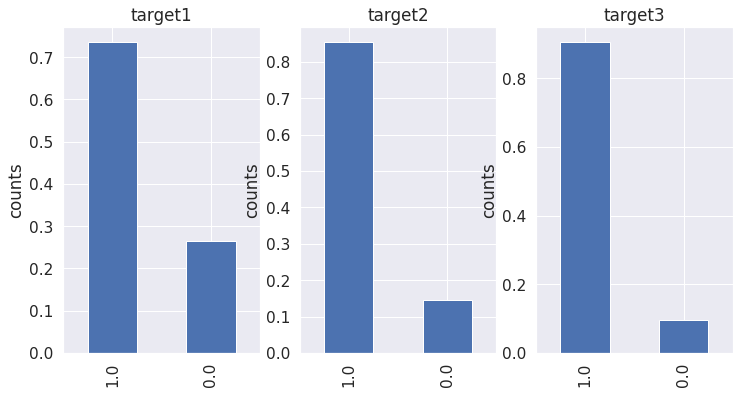

In [359]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
for i,column in zip([0,1,2], [train_1['target1'], train_2['target2'],train_3['target3']]):
    column.value_counts(normalize=True).plot(kind='bar', ax=ax[i], title=column.name,ylabel='counts')

### CORRELATION WITH TARGET

In [360]:
%%time
CORR=True
targets = ['target1', 'target2', 'target3']
dataframes = [train_1, train_2, train_3]

if CORR:
    for df, target in zip(dataframes, targets):
        print('\n\t', target.upper())
        features = [c for c in df.columns if c not in ['User_ID', target]]
        corrs = {}
        for c in tqdm(features):  
            try:
                corrs[c] = np.corrcoef(df[c], df[target])[0][1]
            except:
                pass

        corr_df = pd.DataFrame(corrs, index = [0]).melt().rename(columns={'variable':'FEATURE', 'value': 'CORRELATION'}).sort_values('CORRELATION', ascending=False).dropna()
        display(corr_df.head(20),corr_df.tail(4))


	 TARGET1


100%|██████████| 407/407 [00:00<00:00, 1706.69it/s]


,FEATURE,CORRELATION
387,CompPart,0.904332
393,Target,0.903915
403,Target_shift1,0.672397
394,CompPart_shift1,0.672306
389,m_y,0.641668
386,Start_Time_Day_of_month,0.638337
404,Target_shift2,0.555415
395,CompPart_shift2,0.555340
385,Start_Time_Month,0.524760
338,feature_B_,0.519975


,FEATURE,CORRELATION
382,End_Time_Month,-0.631028
390,end_m_y,-0.684154
392,months_left,-0.789779
391,comp_duration,-0.829287



	 TARGET2


100%|██████████| 407/407 [00:00<00:00, 2053.70it/s]


,FEATURE,CORRELATION
393,Target,0.786343
387,CompPart,0.786125
403,Target_shift1,0.562562
394,CompPart_shift1,0.562446
389,m_y,0.513096
386,Start_Time_Day_of_month,0.505005
404,Target_shift2,0.457686
395,CompPart_shift2,0.457598
338,feature_B_,0.417591
385,Start_Time_Month,0.404315


,FEATURE,CORRELATION
382,End_Time_Month,-0.503266
390,end_m_y,-0.551930
392,months_left,-0.677057
391,comp_duration,-0.700102



	 TARGET3


100%|██████████| 407/407 [00:00<00:00, 2418.27it/s]


,FEATURE,CORRELATION
393,Target,0.694239
387,CompPart,0.693959
403,Target_shift1,0.491272
394,CompPart_shift1,0.491134
389,m_y,0.431277
386,Start_Time_Day_of_month,0.421076
404,Target_shift2,0.398302
395,CompPart_shift2,0.398203
338,feature_B_,0.353532
405,Target_shift3,0.340805


,FEATURE,CORRELATION
382,End_Time_Month,-0.424099
390,end_m_y,-0.467256
392,months_left,-0.583192
391,comp_duration,-0.606914


CPU times: user 698 ms, sys: 11.2 ms, total: 709 ms
Wall time: 704 ms


### HOW HAS ZINDIS USER BASE GROWN OVER TIME?

In [361]:
users.year.unique()

array([1])

In [362]:
# USERS WHO JOINED BEFORE YEAR 4
df = train[['User_ID','month', 'year','day']]
df['count_users'] = df.groupby(['month', 'year', 'day'])['User_ID'].transform('count')
df = df.drop(['User_ID'],1).drop_duplicates()

df = df.sort_values(['year', 'month', 'day'])
df['my'] = df['year'].astype(str) +'_'+ df['month'].astype(str) +'_'+ df['day'].astype(str)
# MAP PREVIOUSLY CREATED DICT TO TRANSFORM MY
df['my'] = df['my'].map(m_ydict)

# USERS WHO JOINED IN YEAR 4 -- Note: We'll need predictions for these users as well
df2 = users[users['year']==1][['User_ID', 'year', 'month','day']]
df2['count_users'] = df2.groupby(['month', 'year','day'])['User_ID'].transform('count')
df2 = df2.drop(['User_ID'],1).drop_duplicates()

df2 = df2.sort_values(['year', 'month','day'])
df2['my'] = df2['year'].astype(str) +'_'+ df2['month'].astype(str) +'_'+df2['day'].astype(str)
    
df2['my'] = df2['my'].map(m_ydict)
#df2.rename(columns={'UserDate_Month':'month', 'UserDate_Year':'year'}, inplace=True)

# APPEND NEW USER COUNTS DF TO END OF OLD USER COUNTS DF
df = df.append(df2)
display(df.tail())

"""df.loc[df['my']==df['my'].unique().max(), 'count_users'] = df[df['my']==df['my'].unique().max()-1]['count_users'].values[0] + df[df['my']==df['my'].unique().max()]['count_users'].values[0]
df.loc[df['my']==df['my'].unique().max()+1, 'count_users'] = df[df['my']==df['my'].unique().max()]['count_users'].values[0] + df[df['my']==df['my'].unique().max()+1]['count_users'].values[0]
df.loc[df['my']==df['my'].unique().max()+2, 'count_users'] = df[df['my']==df['my'].unique().max()+1]['count_users'].values[0] + df[df['my']==df['my'].unique().max()+2]['count_users'].values[0]

display(df.tail())"""

,month,year,day,count_users,my
1763,10,1,23,46,275
1706,10,1,24,68,276
1766,10,1,25,63,277
290,10,1,26,85,278
1487,10,1,27,35,279


"df.loc[df['my']==df['my'].unique().max(), 'count_users'] = df[df['my']==df['my'].unique().max()-1]['count_users'].values[0] + df[df['my']==df['my'].unique().max()]['count_users'].values[0]\ndf.loc[df['my']==df['my'].unique().max()+1, 'count_users'] = df[df['my']==df['my'].unique().max()]['count_users'].values[0] + df[df['my']==df['my'].unique().max()+1]['count_users'].values[0]\ndf.loc[df['my']==df['my'].unique().max()+2, 'count_users'] = df[df['my']==df['my'].unique().max()+1]['count_users'].values[0] + df[df['my']==df['my'].unique().max()+2]['count_users'].values[0]\n\ndisplay(df.tail())"

In [363]:
df = df.sort_values(['year', 'month', 'day'])
df.sample(3)

,month,year,day,count_users,my
191,7,1,25,122,162
409,5,1,16,58,82
21436,4,1,3,4,35


In [364]:
np.sort(df['count_users'])[-5:]

array([ 341,  343,  398,  416, 2389])

In [365]:
df['count_users'][df['count_users']==np.sort(df['count_users'])[-1]] =np.sort(df['count_users'])[-2]

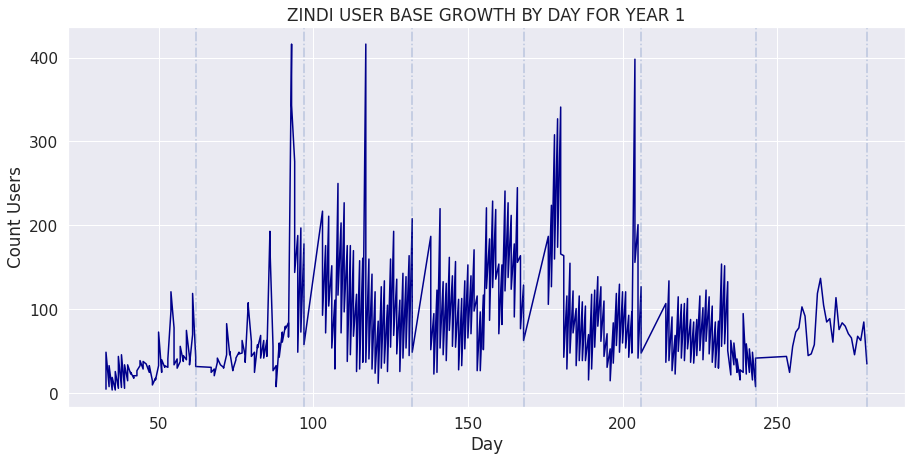

In [366]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['my'].values, df['count_users'].values,  color = 'darkblue')

ax.axvline(x = df[df['month']==4]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==5]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==6]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot') 
ax.axvline(x = df[df['month']==7]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==8]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot')
ax.axvline(x = df[df['month']==9]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot') 
ax.axvline(x = df[df['month']==10]['my'].max(), color = 'b', alpha=0.3, linestyle='dashdot') 

ax.set_title('ZINDI USER BASE GROWTH BY DAY FOR YEAR 1')
ax.set_ylabel('Count Users')
ax.set_xlabel('Day')
plt.show()

---
---

# MODELLING

#### I separated the users into groups of 3 for predicting the next month, and groups of 2 for predicting the following 2 months. Users were grouped based on when they joined Zindi (i.e how many time they appear in the train dataframe)

In [367]:
# GETTING USER VALUE COUNTS
train_vc = train_1['User_ID'].value_counts().to_frame().reset_index()
display(train_vc)

,index,User_ID
0,ID_CEDNKSVV,128
1,ID_0SXRNUSA,77
2,ID_TQM9E72F,65
3,ID_NOPDIGFM,65
4,ID_L3SE5MXW,63
...,...,...
4332,ID_A6QLNSEO,1
4333,ID_MKVEZEY5,1
4334,ID_A8EW7SV5,1
4335,ID_A8J6U1H4,1


<AxesSubplot:xlabel='Value Count', ylabel='Density'>

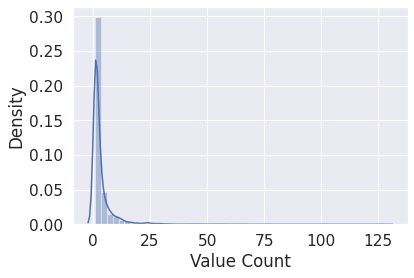

In [368]:
# COUNTS OF HOW MANY USERS SHARE THE SAME VALUE COUNTS
series = train_vc['User_ID']
series.name = 'Value Count'
sns.distplot(train_vc['User_ID'], bins=50)

#### GROUPING THE USERS

In [369]:
# CLUSTER 1 CONTAINS ALL USERS WHO JOINED ZINDI 17 MONTHS AGO OR LATER
c1 = train_vc[train_vc['User_ID']>=17]['index'].tolist()
print(len(c1))

# CLUSTER 3 CONTAINS ALL USERS WHO JOINED ZINDI 6 MONTHS AGO OR EARLIER
c3 = train_vc[train_vc['User_ID']<=6]['index'].tolist()
print(len(c3))

# WE WILL ADD MORE USERS TO CLUSTER 3 FOR TRAINING PURPOSES (MORE DATA) BUT 
# WILL NOT USE THIS MODEL TO PREDICT ON THESE ADDED USERS
### HERE WE SELECT USERS WHO JOINED ZINDI 11 MONTHS AGO OR LATER AND
### WE'LL EXCLUDE THESE USERS FROM THE DATA USED TO TRAIN AND PREDICT
### FOR CLUSTER 3 USERS
c3_1 = train_vc[train_vc['User_ID']>=11]['index'].tolist()
print(len(c3_1))

# AND CLUSTER 2 USERS WILL BE USERS NOT IN CLUSTER 1 OR 3

126
3799
279


In [370]:
# WE WILL ONLY SELECT DATA POINTS FROM THE MOST RECENT YEAR
train_1 = train_1[train_1['year']==1]
train_2 = train_2[train_2['year']==1]
train_3 = train_3[train_3['year']==1]

In [371]:
# SUBSET OUR DATAFRAMES FOR EACH USER GROUP
train1_c1 = train_1[train_1['User_ID'].isin(c1)]
print(train1_c1.shape)
# ---- train1_c2 is just train_1
train1_c3 = train_1[~train_1['User_ID'].isin(c3_1)]
print(train1_c3.shape)

train2_c1 = train_2[train_2['User_ID'].isin(c1)]
print(train2_c1.shape)
# ---- train2_c2 is just train_2

train3_c1 = train_3[train_3['User_ID'].isin(c1)]
print(train3_c1.shape)
# ---- train3_c2 is just train_3

(3603, 409)
(9404, 409)
(3477, 409)
(3351, 409)


#### PARTION THE TEST DATA BY USER GROUP

In [372]:
# SAVE USER ORDER IN TEST DATASET
for_test_user_order = for_test[['User_ID']].set_index(['User_ID'])
display(for_test_user_order.head())
print(for_test_user_order.shape)

# GROUP 1 USERS
for_test_c1 = for_test[for_test['User_ID'].isin(c1)]
print(for_test_c1.shape)

# GROUP 2 USERS ARENT IN GROUP ONE OR GROUP 3
for_test_c2 = for_test[~for_test['User_ID'].isin(c1)]
for_test_c2 = for_test_c2[~for_test_c2['User_ID'].isin(c3)]
print(for_test_c2.shape)

# GROUP 3 USERS ARE THE MOST RECENT USERS, THEY ARE NOT IN GROUP 1 OR 2
not_c3 = list(for_test_c2['User_ID'].unique()) + list(for_test_c1['User_ID'].unique())
for_test_c3 = for_test[~for_test['User_ID'].isin(not_c3)]
print(for_test_c3.shape)

# DOES IT ALL ADD UP?
print(for_test_c1.shape[0]+for_test_c2.shape[0]+for_test_c3.shape[0])

""
User_ID
ID_000H9XOP
ID_000H9XOP
ID_02CJSF31
ID_02NBP9MC
ID_031ICJEF


(4048, 0)
(300, 408)
(3429, 408)
(319, 408)
4048


### REOMVE OUTLIERS

In [373]:
def remove_outliers(df, columns, threshold, return_df=True):
    df = df.copy()
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = sc.stats.norm.ppf(q=threshold / 2, loc=0, scale=1)
    upper_bound = sc.stats.norm.ppf(q=1 - threshold / 2, loc=0, scale=1)

    # Calculate X scores for affected columns
    outlier_df = df.loc[:, columns].copy().astype(float)
    
    zscores = pd.DataFrame(sc.stats.zscore(outlier_df, axis=0),
                           index=outlier_df.index,
                           columns=outlier_df.columns)

    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)

    # Get indicies of all outlier examples
    outliers = list(df[pd.concat([lower_outliers, upper_outliers],
                            axis=1).any(axis=1)].index)
    
    del zscores,lower_outliers,upper_outliers,outlier_df,columns
    gc.collect()
    
    if return_df:
        # Drop the outliers
        df = df.drop(outliers, axis=0).reset_index(drop=True)

        return df, outliers
    else: 
        return outliers

def noise_removal(df, target_name, targets, threshold, col_thresholds,return_df=True):
    print(f'\n\n{target_name.upper()}\n')
    less_noisy = pd.DataFrame()
    all_the_noise = []
    
    # SELECTING WHICH COLUMNS TO USE IN FINDING OUTLIERS BY CONSIDERING THE 
    # AMOUNT OF UNIQUE VALUES IN THE COLUMN
    tempdf = df.drop(['User_ID','Comp_ID'], axis=1).copy()
    features = [c for c in tempdf.columns if c not in ['User_ID','Comp_ID', 'month', 'year', 'day']]
    nunique_df = pd.DataFrame()

    for col in features:
        nunique_df[col] = [tempdf[col].nunique()]

    nunique_df = nunique_df.T.reset_index()
    nunique_df.rename(columns={0:'n_unique', 'index':'feature'}, inplace=True)
    nunique_df = nunique_df.sort_values(['n_unique'])
    
    col_threshold_min, col_threshold_max = col_thresholds[0], col_thresholds[1]
    # GET THE COLUMNS WITHIN THE N_UNIQUE BOUNDARIES
    numerical_columns = nunique_df[nunique_df['n_unique'].isin(range(col_threshold_min,
                                                                     col_threshold_max))]['feature'].tolist()
    
    del tempdf
    
    # REMOVE OUTLIERS WITHIN TARGET
    for target in targets: 
        targetdf = df.loc[df[target_name]==target] 
        if return_df:
            less_noise, the_noise = remove_outliers(df=targetdf,
                                    columns=numerical_columns,
                                    threshold=threshold,
                                    return_df=True) 
            less_noisy = less_noisy.append([less_noise]) 
            del less_noise
            
        else:
            the_noise = remove_outliers(df=targetdf,
                                        columns=numerical_columns,
                                        threshold=threshold,
                                        return_df=False) 
        
        all_the_noise += the_noise 
        
        print(f'Targeted {len(the_noise)} outliers from target {target}')
        del targetdf, the_noise
        gc.collect()

    del numerical_columns
    gc.collect()

    print('Train df:\t\t\t',df.shape)
    print('\n Noise:',len(all_the_noise), '\n')
    
    if return_df:
        print('Train df after removing ouliers within each target group:', less_noisy.shape)
        return less_noisy
    else:
        return all_the_noise

#### ONLY LOOKING FOR OUTLIERS WITHIN GROUP 2, AS THIS GROUP WILL BE TRAINIED ON ALL THE DATA, BUT PREDICTING FOR THOSE ONLY IN GROUP 2

In [374]:
%%time
return_df = False
train_1_outliers = noise_removal(train_1, 'target1',[0,1], 0.00000005, [15,1500], return_df=return_df)
train_2_outliers = noise_removal(train_2, 'target2',[0,1], 0.000000000025, [15,1500], return_df=return_df)



TARGET1

Targeted 73 outliers from target 0
Targeted 44 outliers from target 1
Train df:			 (14961, 409)

 Noise: 117 



TARGET2

Targeted 26 outliers from target 0
Targeted 29 outliers from target 1
Train df:			 (10624, 409)

 Noise: 55 

CPU times: user 2.13 s, sys: 7.11 ms, total: 2.14 s
Wall time: 2.13 s


In [375]:
outliers_train_1 = train_1.loc[train_1_outliers]
# ONLY CONSIDER REMOVING THE OUTLIERS NOT FROM GROUP 2
outliers_train_1 = outliers_train_1[outliers_train_1['User_ID'].isin(c1)]
display(outliers_train_1)
print(outliers_train_1['target1'].value_counts())

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target1
584,ID_1IXLFBL0,5,1,15,1,6.0,3.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,81,33,280,247,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2372,ID_5UHEPVJB,5,1,20,1,8.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

1.0    17
0.0    12
Name: target1, dtype: int64


In [376]:
outliers_train_2 = train_2.loc[train_2_outliers]
# ONLY CONSIDER REMOVING THE OUTLIERS NOT FROM GROUP 2
outliers_train_2 = outliers_train_2[outliers_train_2['User_ID'].isin(c1)]
display(outliers_train_2)
print(outliers_train_2['target2'].value_counts())

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_19.0,FeatureC_20.0,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target2
910,ID_5UHEPVJB,5,1,20,1,8.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,86,33,280,247,194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1061,ID_5UHEPVJB,5,1,23,1,7.0,3.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

1.0    13
0.0     6
Name: target2, dtype: int64


In [377]:
# GET THE INDEX OF THE OUTLIERS NOT FROM GROUP 2
out1 = outliers_train_1.index
out2 = outliers_train_2.index

---

---

# MODEL TRAINING

## LIGHT GBM _ NO.1
## Predicting for seen users

In [378]:
set_seed(42)

params_lgbm1 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary',
               'min_data_in_leaf':  33,
               'num_leaves':        50,
               'max_depth':         20,
               'n_estimators':      5000,
               'path_smooth':       500,
               'n_jobs':            -1,
               'first_metric_only': True,
               'learning_rate':     0.007}

params_lgbm2 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary',
               'min_data_in_leaf':  40,
               'num_leaves':        90,
               'max_depth':         12,
               'n_estimators':      4000,
               'path_smooth':       30,
               'n_jobs':            -1,
               'first_metric_only': True,
               'learning_rate':     0.01}

params_lgbm3 = {'boosting_type':     'gbdt',   
               'verbosity':         -1,
               'seed':              1,
               'objective':         'binary',
               'min_data_in_leaf':  35,
               'num_leaves':        75,
               'max_depth':         11,
               'n_estimators':      4000,
               'path_smooth':       10,
               'n_jobs':            -1,
               'first_metric_only': True,
               'learning_rate':     0.009}

model1 = LGBMClassifier(**params_lgbm1)
model2 = LGBMClassifier(**params_lgbm2)
model3 = LGBMClassifier(**params_lgbm3)

In [379]:
def evaluate_lgb(x, y, test_, cv, params_lgbm, prefix='', task='TRAIN', path=''):

    kfold = KFold(n_splits = cv, random_state = 1, shuffle = True)

    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    test_predictions = np.zeros(test_.shape[0])
    
    feature_importances = np.zeros(x.shape[1])
    
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):

        X_train, X_test = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_test = y.iloc[trn_ind], y.iloc[val_ind]

        print('Training Data: ',X_train.shape, y_train.shape)
        print('Validation Data: ',X_test.shape, y_test.shape, '\n')
        
        if task=='TRAIN':
            print('\n','*'*7,f'Training fold {fold + 1}','*'*7, '\n')
            model = LGBMClassifier(**params_lgbm)
            model.fit(   
                        X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        eval_metric=['auc'],
                        early_stopping_rounds=100,
                        verbose=100
                     )  
            with open(f'lgb_model{prefix}_useractivity_fold_{fold+1}.pkl', 'wb') as file:
                pickle.dump(model, file)  
        
        else:
            print('\n','*'*7,f'Predicting fold {fold + 1}','*'*7, '\n')
            with open(path+f'lgb_model{prefix}_useractivity_fold_{fold+1}.pkl', 'rb') as file:
                model = pickle.load(file)
                    
        gc.collect()
        pred = model.predict_proba(X_test.values)[:,1]
        pred_train = model.predict_proba(X_train.values)[:,1]
        test_auc = roc_auc_score(y_test, pred)
        train_auc = roc_auc_score(y_train, pred_train)
        print(f'AUC TEST: {test_auc}')
        print(f'AUC TRAIN: {train_auc}')
        
        oof_predictions[val_ind] = pred
        
        test_pred = model.predict_proba(test_.values)[:,1] 
        test_predictions += test_pred / cv
        
        feature_importances += model.feature_importances_ / cv
        
        del X_train, y_train, X_test, y_test
        gc.collect()
    
    return test_predictions.reshape(-1,1), oof_predictions.reshape(-1,1), feature_importances

def get_importance_plot(feature_importances_, columns):
    
    feature_importances = pd.DataFrame({'feature': columns, 
                                        'importance': feature_importances_}).sort_values('importance',ascending = False) 

    # Cumulative importance plot
    feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

    plt.figure(figsize = (10, 15))
    plt.barh(feature_importances.sort_values('importance')['feature'][-30:], feature_importances.sort_values('importance')['importance'][-30:])
    plt.xlabel('Importance', size=14) 
    plt.title('Feature Importance', size=17)
    plt.grid(True)
    plt.show()

    plt.figure(figsize = (7, 4))
    plt.plot(list(range(len(feature_importances))), feature_importances['cumulative_importance'], 'b')
    plt.xlabel('Number of Features', size=11) 
    plt.ylabel('Cumulative Importance', size=11)
    plt.title('Cumulative Feature Importance', size=15)
    plt.grid(True)
    plt.show()

    num_important = feature_importances[feature_importances['cumulative_importance']< 0.993][['feature', 'importance']].shape[0]
    print(f'{num_important} Features accounts for 99.3% of the cumulative importance.')

    # ranked features
    important_x =  feature_importances['feature'].tolist()
    return important_x

In [380]:
model_path = '../input/user-act-prediction/'
task = 'TRAIN'

### Target 1 Cluster 1

In [381]:
FS = False
features1 = []
drop = ['year']
target = 'target1'

if FS:
    X = train1_c1[train1_c1['month']>1][features1]
    for_test_1 = for_test_c1[features1]
else: 
    X = train1_c1[train1_c1['month']>1].drop(['User_ID', 'Comp_ID', target]+drop,1)
    for_test_1 = for_test_c1.drop(['User_ID','Comp_ID']+drop,1)
    
y = train1_c1[train1_c1['month']>1][[target]]

print(X.shape, y.shape, for_test_1.shape)

(3603, 405) (3603, 1) (300, 405)


In [382]:
train1_c1['month'].unique()

array([4, 5, 9, 7, 8, 6], dtype=int8)

In [383]:
np.unique(y)

array([0., 1.], dtype=float16)

In [384]:
%%time
test_predictions1c1,oof_predictions1c1,feature_importances1c1 = evaluate_lgb(X, y, for_test_1, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c1',
                                                                             task=task, path=model_path)

Training Data:  (3362, 405) (3362, 1)
Validation Data:  (241, 405) (241, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995777	training's binary_logloss: 0.0702697	valid_1's auc: 0.997253	valid_1's binary_logloss: 0.061055
[200]	training's auc: 0.996223	training's binary_logloss: 0.0468827	valid_1's auc: 1	valid_1's binary_logloss: 0.0387433
Early stopping, best iteration is:
[158]	training's auc: 0.996212	training's binary_logloss: 0.0538637	valid_1's auc: 1	valid_1's binary_logloss: 0.0456573
Evaluated only: auc
AUC TEST: 1.0
AUC TRAIN: 0.9962124504497386
Training Data:  (3362, 405) (3362, 1)
Validation Data:  (241, 405) (241, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3

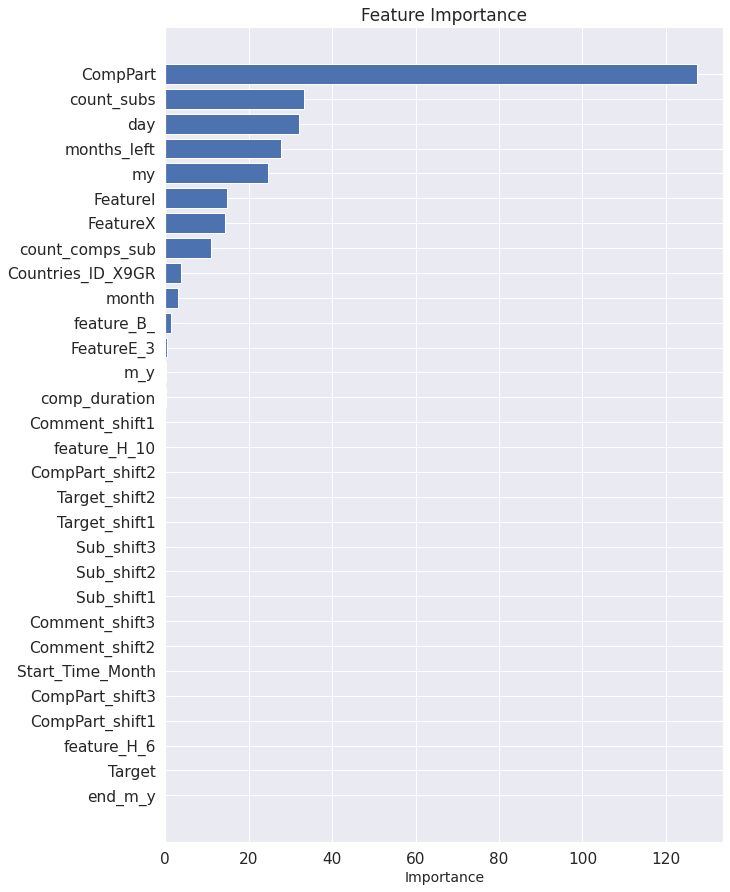

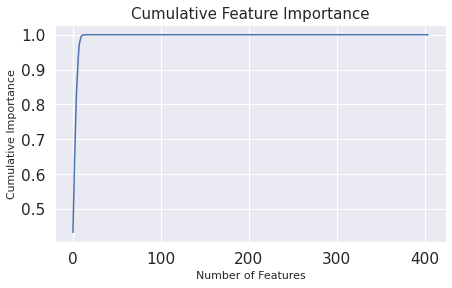

10 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 1: 0.9927166686756483

[[  13  111]
 [   6 3473]] 

              precision    recall  f1-score   support

         0.0       0.68      0.10      0.18       124
         1.0       0.97      1.00      0.98      3479

    accuracy                           0.97      3603
   macro avg       0.83      0.55      0.58      3603
weighted avg       0.96      0.97      0.96      3603



In [385]:
test_auc1c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c1.reshape(-1,1))
importantx1c1 = get_importance_plot(feature_importances1c1, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 1: {test_auc1c1}\n')
oof_pred1_01c1 = np.round(oof_predictions1c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c1))

all_ys = []
all_preds = []
all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c1)

### Target 1 Cluster 2

In [386]:
FS = False
features1 = []
drop = ['year']
target = 'target1'

if FS:
    X = train_1[features1]
    for_test_1 = for_test_c2[features1]
else: 
    # DROPPING USERID, TARGET AND OUTLIERS
    X = train_1.drop(['Comp_ID','User_ID', target]+drop,1).drop(out1, 0)
    for_test_1 = for_test_c2.drop(['User_ID','Comp_ID']+drop,1)
    
y = train_1[[target]].drop(out1, 0)

print(X.shape, y.shape, for_test_1.shape)

(14932, 405) (14932, 1) (3429, 405)


In [387]:
%%time
test_predictions1c2,oof_predictions1c2,feature_importances1c2 = evaluate_lgb(X, y, for_test_1, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c2',
                                                                             task=task, path=model_path)

Training Data:  (13936, 405) (13936, 1)
Validation Data:  (996, 405) (996, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.990082	training's binary_logloss: 0.272819	valid_1's auc: 0.991726	valid_1's binary_logloss: 0.268918
Early stopping, best iteration is:
[26]	training's auc: 0.98986	training's binary_logloss: 0.453898	valid_1's auc: 0.992133	valid_1's binary_logloss: 0.456287
Evaluated only: auc
AUC TEST: 0.9921329699380762
AUC TRAIN: 0.9898599139893999
Training Data:  (13936, 405) (13936, 1)
Validation Data:  (996, 405) (996, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.990305	train

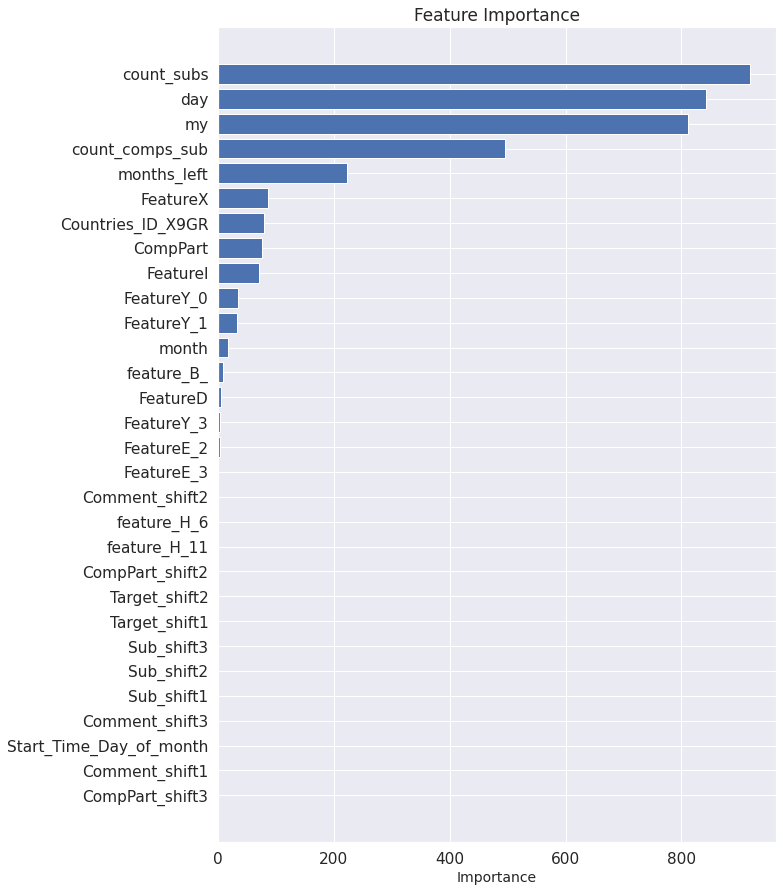

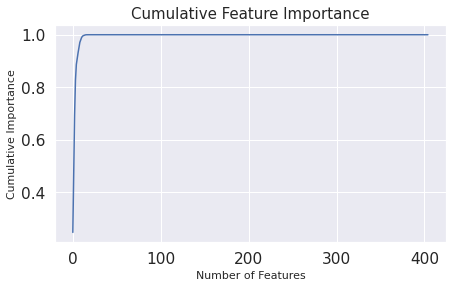

11 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 2: 0.9760369283059923

[[ 1247  2706]
 [  115 10864]] 

              precision    recall  f1-score   support

         0.0       0.92      0.32      0.47      3953
         1.0       0.80      0.99      0.89     10979

    accuracy                           0.81     14932
   macro avg       0.86      0.65      0.68     14932
weighted avg       0.83      0.81      0.77     14932



In [388]:
test_auc1c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c2.reshape(-1,1))
importantx1c2 = get_importance_plot(feature_importances1c2, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 2: {test_auc1c2}\n')
oof_pred1_01c2 = np.round(oof_predictions1c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c2)

### Target 1 Cluster 3

In [389]:
drop = ['year']
target = 'target1'

if FS:
    X = train1_c3[features1]
    for_test_1 = for_test_c3[features1]
else: 
    X = train1_c3.drop(['Comp_ID', 'User_ID', target]+drop,1)
    for_test_1 = for_test_c3.drop(['User_ID','Comp_ID']+drop,1)
    
y = train1_c3[[target]]

print(X.shape, y.shape, for_test_1.shape)

(9404, 405) (9404, 1) (319, 405)


In [390]:
%%time
test_predictions1c3,oof_predictions1c3,feature_importances1c3 = evaluate_lgb(X, y, for_test_1, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm1,
                                                                             prefix='target1c3',
                                                                             task=task, path=model_path)

Training Data:  (8777, 405) (8777, 1)
Validation Data:  (627, 405) (627, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.985511	training's binary_logloss: 0.341195	valid_1's auc: 0.97768	valid_1's binary_logloss: 0.351114
Early stopping, best iteration is:
[9]	training's auc: 0.984248	training's binary_logloss: 0.620961	valid_1's auc: 0.979509	valid_1's binary_logloss: 0.616954
Evaluated only: auc
AUC TEST: 0.979508817483501
AUC TRAIN: 0.9842478083203804
Training Data:  (8777, 405) (8777, 1)
Validation Data:  (627, 405) (627, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.985382	training's 

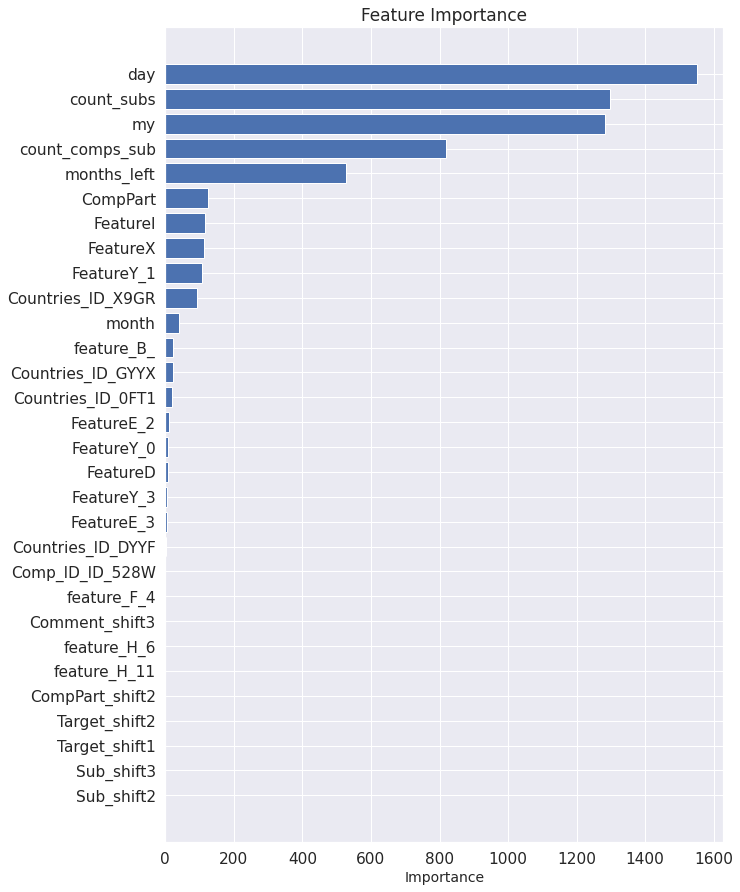

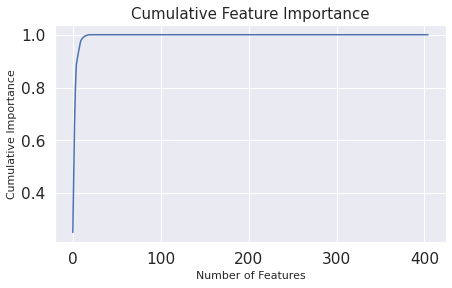

13 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET1 CLUSTER 3: 0.9651095870997745

[[1691 1985]
 [ 173 5555]] 

              precision    recall  f1-score   support

         0.0       0.91      0.46      0.61      3676
         1.0       0.74      0.97      0.84      5728

    accuracy                           0.77      9404
   macro avg       0.82      0.71      0.72      9404
weighted avg       0.80      0.77      0.75      9404



In [391]:
test_auc1c3 = roc_auc_score(y.values.reshape(-1,1), oof_predictions1c3.reshape(-1,1))
importantx1c3 = get_importance_plot(feature_importances1c3, list(X.columns))

print(f'TEST AUC TARGET1 CLUSTER 3: {test_auc1c3}\n')
oof_pred1_01c3 = np.round(oof_predictions1c3,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred1_01c3), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred1_01c3))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions1c3)

In [392]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 1 MONTH AHEAD
for_test_c1['target1'] = test_predictions1c1
for_test_c2['target1'] = test_predictions1c2
for_test_c3['target1'] = test_predictions1c3
for_test_c123 = for_test_c1[['User_ID','target1']].append(for_test_c2[['User_ID','target1']]).append(for_test_c3[['User_ID','target1']])
#for_test_c123 = for_test_c123.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c123 = for_test_c123.reset_index()
test_predictions1 = for_test_c123['target1'].values.reshape(-1,1)

del for_test_c123, for_test_c1['target1'], for_test_c2['target1'], for_test_c3
gc.collect()

9279

### Target 2 Cluster 1

In [393]:
for_test_c2 = for_test[~for_test['User_ID'].isin(c1)]
print(for_test_c2.shape)

(3748, 408)


In [394]:
FS = False
features2 = []
drop = ['year']

In [395]:
target = 'target2'
if FS:
    X = train_2[features2]
    for_test_2 = for_test[features2]
else: 
    X = train2_c1.drop(['User_ID', 'Comp_ID', target]+drop,1)
    for_test_2 = for_test_c1.drop(['User_ID', 'Comp_ID']+drop,1)
    
y = train2_c1[[target]]

print(X.shape, y.shape, for_test_2.shape)

(3477, 405) (3477, 1) (300, 405)


In [396]:
%%time
test_predictions2c1,oof_predictions2c1,feature_importances2c1 = evaluate_lgb(X, y, for_test_2, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm2,
                                                                             prefix='target2c1',
                                                                             task=task, path=model_path)

Training Data:  (3245, 405) (3245, 1)
Validation Data:  (232, 405) (232, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995741	training's binary_logloss: 0.0413959	valid_1's auc: 0.98298	valid_1's binary_logloss: 0.0661572
[200]	training's auc: 0.996452	training's binary_logloss: 0.0292788	valid_1's auc: 0.984375	valid_1's binary_logloss: 0.0507323
Early stopping, best iteration is:
[124]	training's auc: 0.995845	training's binary_logloss: 0.0373872	valid_1's auc: 0.984375	valid_1's binary_logloss: 0.0614202
Evaluated only: auc
AUC TEST: 0.984375
AUC TRAIN: 0.9958451228592703
Training Data:  (3245, 405) (3245, 1)
Validation Data:  (232, 405) (232, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value:

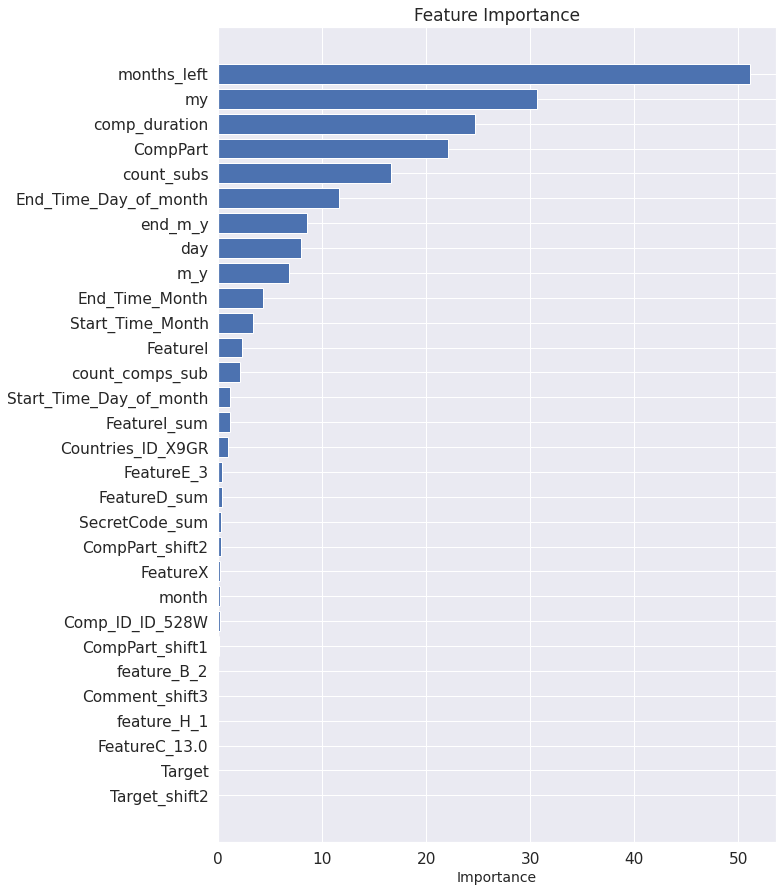

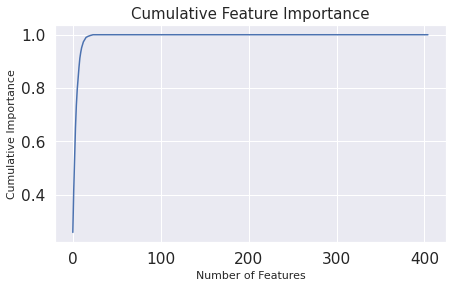

17 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET2 CLUSTER 1: 0.9893045069778083

[[   6   87]
 [   4 3380]] 

              precision    recall  f1-score   support

         0.0       0.60      0.06      0.12        93
         1.0       0.97      1.00      0.99      3384

    accuracy                           0.97      3477
   macro avg       0.79      0.53      0.55      3477
weighted avg       0.96      0.97      0.96      3477



In [397]:
test_auc2c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions2c1.reshape(-1,1))
importantx2c1 = get_importance_plot(feature_importances2c1, list(X.columns))

print(f'TEST AUC TARGET2 CLUSTER 1: {test_auc2c1}\n')
oof_pred2_01c1 = np.round(oof_predictions2c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred2_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred2_01c1))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions2c1)

### Target 2 Cluster 2

In [398]:
FS = False
features2 = []
drop = ['year']

In [399]:
target = 'target2'
if FS:
    X = train_2[features2]
    for_test_2 = for_test[features2]
else: 
    # DROPPING USERID, TARGET AND OUTLIERS
    X = train_2.drop(['User_ID', 'Comp_ID', target]+drop,1).drop(out2, 0)
    for_test_2 = for_test_c2.drop(['User_ID', 'Comp_ID']+drop,1)
    
y = train_2[[target]].drop(out2, 0)

print(X.shape, y.shape, for_test_2.shape)

(10605, 405) (10605, 1) (3748, 405)


In [400]:
%%time
test_predictions2c2,oof_predictions2c2,feature_importances2c2 = evaluate_lgb(X, y, for_test_2, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm2,
                                                                             prefix='target2c2',
                                                                             task=task, path=model_path)

Training Data:  (9898, 405) (9898, 1)
Validation Data:  (707, 405) (707, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.987634	training's binary_logloss: 0.168681	valid_1's auc: 0.979235	valid_1's binary_logloss: 0.176987
[200]	training's auc: 0.988419	training's binary_logloss: 0.117795	valid_1's auc: 0.979201	valid_1's binary_logloss: 0.137645
Early stopping, best iteration is:
[124]	training's auc: 0.98791	training's binary_logloss: 0.150272	valid_1's auc: 0.979448	valid_1's binary_logloss: 0.162111
Evaluated only: auc
AUC TEST: 0.9794479678123296
AUC TRAIN: 0.9879102896516843
Training Data:  (9898, 405) (9898, 1)
Validation Data:  (707, 405) (707, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current va

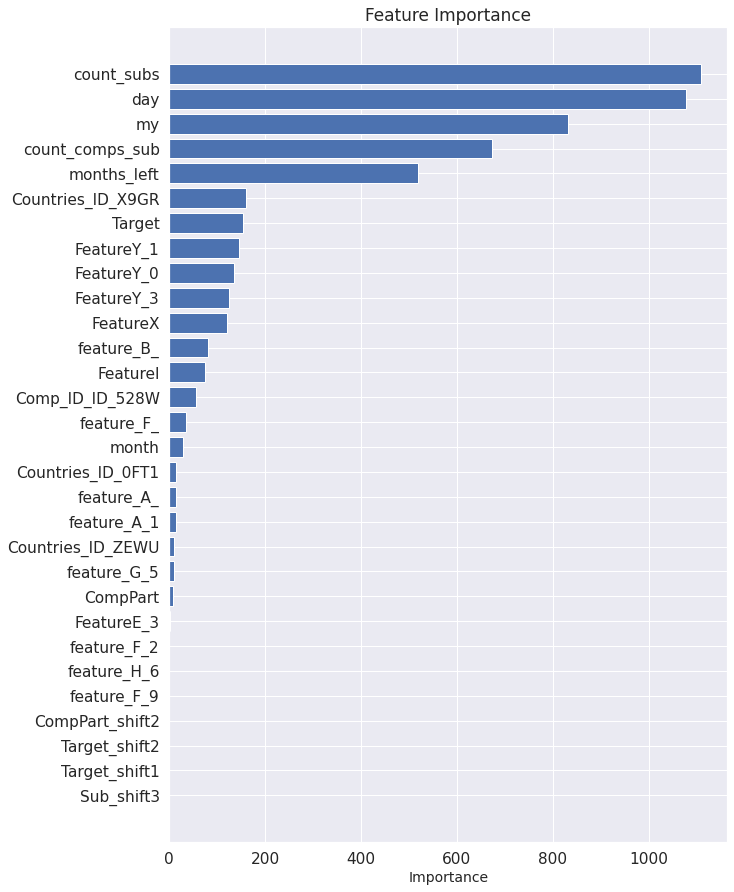

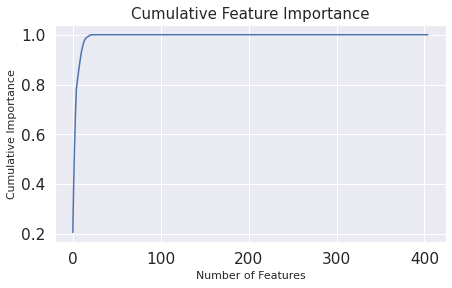

18 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET2 CLUSTER 2: 0.9725153060859999

[[ 823  722]
 [ 249 8811]] 

              precision    recall  f1-score   support

         0.0       0.77      0.53      0.63      1545
         1.0       0.92      0.97      0.95      9060

    accuracy                           0.91     10605
   macro avg       0.85      0.75      0.79     10605
weighted avg       0.90      0.91      0.90     10605



In [401]:
test_auc2c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions2c2.reshape(-1,1))
importantx2c2 = get_importance_plot(feature_importances2c2, list(X.columns))

print(f'TEST AUC TARGET2 CLUSTER 2: {test_auc2c2}\n')
oof_pred2_01c2 = np.round(oof_predictions2c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred2_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred2_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions2c2)

In [402]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 2 MONTHS AHEAD
for_test_c1['target2'] = test_predictions2c1
for_test_c2['target2'] = test_predictions2c2
for_test_c12 = for_test_c1[['User_ID','target2']].append(for_test_c2[['User_ID','target2']])
#for_test_c12 = for_test_c12.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c12 = for_test_c12.reset_index()
test_predictions2 = for_test_c12['target2'].values.reshape(-1,1)

del for_test_c12, for_test_c1['target2'], for_test_c2['target2']
gc.collect()

9127

### Target 3 Cluster 1

In [403]:
FS = False
features3 = []
drop = ['year']
target = 'target3'

if FS:
    X = train3_c1[features3]
    for_test_3 = for_test_c1[features3]
else: 
    X = train3_c1.drop(['User_ID', 'Comp_ID', target]+drop,1)
    for_test_3 = for_test_c1.drop(['User_ID', 'Comp_ID']+drop,1)
    
y = train3_c1[[target]]

print(X.shape, y.shape, for_test_3.shape)

(3351, 405) (3351, 1) (300, 405)


In [404]:
%%time
test_predictions3c1,oof_predictions3c1,feature_importances3c1 = evaluate_lgb(X, y, for_test_3, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm3,
                                                                             prefix='target3c1',
                                                                             task=task, path=model_path)

Training Data:  (3127, 405) (3127, 1)
Validation Data:  (224, 405) (224, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995115	training's binary_logloss: 0.0388933	valid_1's auc: 0.990868	valid_1's binary_logloss: 0.0423737
Early stopping, best iteration is:
[10]	training's auc: 0.994286	training's binary_logloss: 0.078247	valid_1's auc: 0.993607	valid_1's binary_logloss: 0.0824103
Evaluated only: auc
AUC TEST: 0.993607305936073
AUC TRAIN: 0.9942859233245537
Training Data:  (3127, 405) (3127, 1)
Validation Data:  (224, 405) (224, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995186	traini

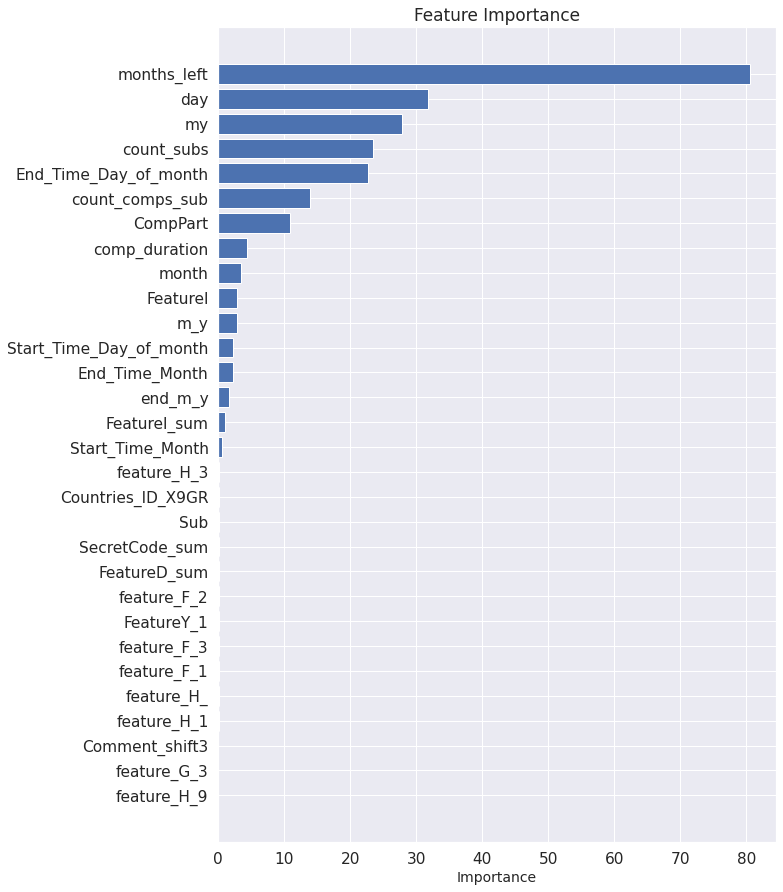

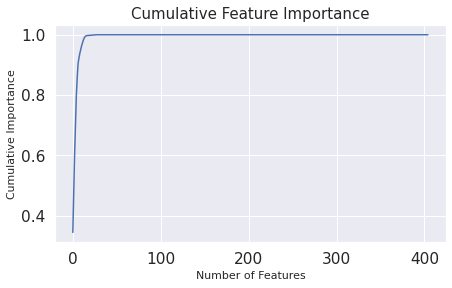

14 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET3 CLUSTER 1: 0.9874771271729186

[[   3   69]
 [   0 3279]] 

              precision    recall  f1-score   support

         0.0       1.00      0.04      0.08        72
         1.0       0.98      1.00      0.99      3279

    accuracy                           0.98      3351
   macro avg       0.99      0.52      0.53      3351
weighted avg       0.98      0.98      0.97      3351



In [405]:
test_auc3c1 = roc_auc_score(y.values.reshape(-1,1), oof_predictions3c1.reshape(-1,1))
importantx3c1 = get_importance_plot(feature_importances3c1, list(X.columns))

print(f'TEST AUC TARGET3 CLUSTER 1: {test_auc3c1}\n')
oof_pred3_01c1 = np.round(oof_predictions3c1,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred3_01c1), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred3_01c1))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions3c1)

### Target 3 Cluster 2

In [406]:
FS = False
features3 = []
drop = ['year']
target = 'target3'

if FS:
    X = train_3[features3]
    for_test_3 = for_test_c2[features3]
else: 
    X = train_3.drop(['User_ID', 'Comp_ID', target]+drop,1)
    for_test_3 = for_test_c2.drop(['User_ID', 'Comp_ID']+drop,1)
    
y = train_3[[target]]

print(X.shape, y.shape, for_test_3.shape)

(8409, 405) (8409, 1) (3748, 405)


In [407]:
%%time
test_predictions3c2,oof_predictions3c2,feature_importances3c2 = evaluate_lgb(X, y, for_test_3, 
                                                                             cv=15, 
                                                                             params_lgbm=params_lgbm3,
                                                                             prefix='target3c2',
                                                                             task=task, path=model_path)

Training Data:  (7848, 405) (7848, 1)
Validation Data:  (561, 405) (561, 1) 


 ******* Training fold 1 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.985415	training's binary_logloss: 0.143712	valid_1's auc: 0.985116	valid_1's binary_logloss: 0.130572
Early stopping, best iteration is:
[17]	training's auc: 0.981225	training's binary_logloss: 0.251476	valid_1's auc: 0.98605	valid_1's binary_logloss: 0.232021
Evaluated only: auc
AUC TEST: 0.9860501949317738
AUC TRAIN: 0.9812245633461962
Training Data:  (7848, 405) (7848, 1)
Validation Data:  (561, 405) (561, 1) 


 ******* Training fold 2 ******* 

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.986164	training'

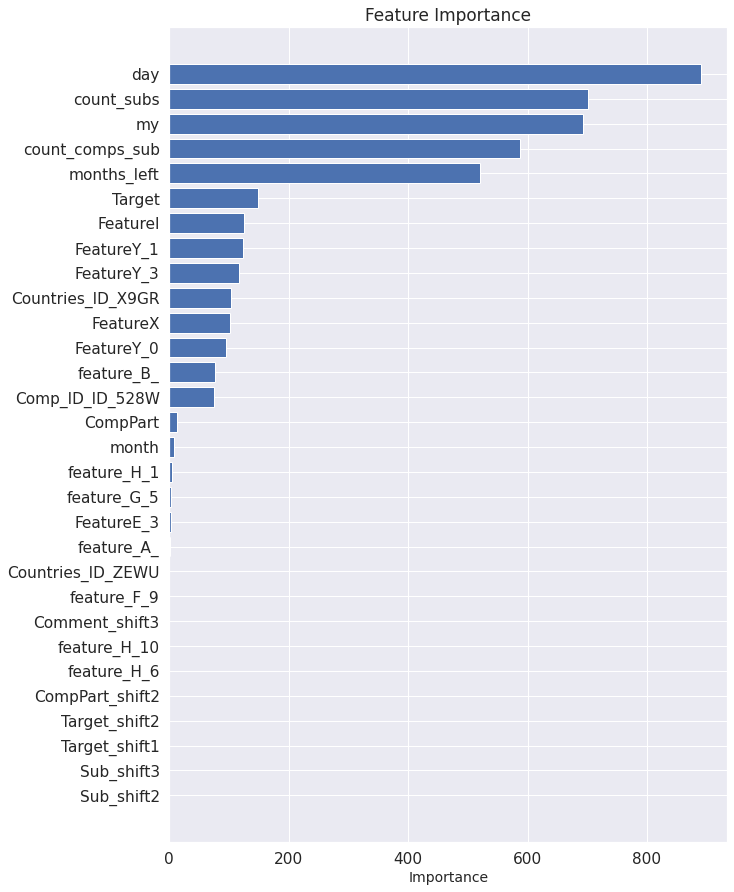

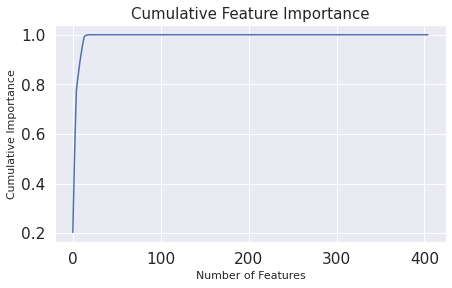

14 Features accounts for 99.3% of the cumulative importance.
TEST AUC TARGET3 CLUSTER 2: 0.9714249483186407

[[ 331  472]
 [ 116 7490]] 

              precision    recall  f1-score   support

         0.0       0.74      0.41      0.53       803
         1.0       0.94      0.98      0.96      7606

    accuracy                           0.93      8409
   macro avg       0.84      0.70      0.75      8409
weighted avg       0.92      0.93      0.92      8409



In [408]:
test_auc3c2 = roc_auc_score(y.values.reshape(-1,1), oof_predictions3c2.reshape(-1,1))
importantx3c2 = get_importance_plot(feature_importances3c2, list(X.columns))

print(f'TEST AUC TARGET3 CLUSTER 2: {test_auc3c2}\n')
oof_pred3_01c2 = np.round(oof_predictions3c2,0)
print(metrics.confusion_matrix(y.values.reshape(-1,1), oof_pred3_01c2), '\n')
print(metrics.classification_report(y.values.reshape(-1,1), oof_pred3_01c2))

all_ys.append(y.values.reshape(-1,1))
all_preds.append(oof_predictions3c2)

In [409]:
# MERGING AND REORDERING OF TEST PREDICTIONS FOR 3 MONTHS AHEAD
for_test_c1['target3'] = test_predictions3c1
for_test_c2['target3'] = test_predictions3c2
for_test_c12 = for_test_c1[['User_ID','target3']].append(for_test_c2[['User_ID','target3']])
#for_test_c12 = for_test_c12.set_index('User_ID').reindex(for_test_user_order.index)
for_test_c12 = for_test_c12.reset_index()
test_predictions3 = for_test_c12['target3'].values.reshape(-1,1)

del for_test_c12, for_test_c1, for_test_c2
gc.collect()

9051

In [410]:
# DELETE OLD VARIABLES
del for_test_1, for_test_2, for_test_3, X, y

---

### OUT OF FOLD CV SCORE

In [411]:
all_ys = np.vstack(all_ys)
all_preds = np.vstack(all_preds)

test_auc = roc_auc_score(all_ys,all_preds)

print(f'TEST AUC: {test_auc}\n')
oof_preds = np.round(all_preds,0)
print(metrics.confusion_matrix(all_ys, oof_preds), '\n')
print(metrics.classification_report(all_ys, oof_preds))

TEST AUC: 0.9472204196590839

[[ 4114  6152]
 [  663 42852]] 

              precision    recall  f1-score   support

         0.0       0.86      0.40      0.55     10266
         1.0       0.87      0.98      0.93     43515

    accuracy                           0.87     53781
   macro avg       0.87      0.69      0.74     53781
weighted avg       0.87      0.87      0.85     53781



In [412]:
print(f'TEST AUC TARGET1 C1: {test_auc1c1}')
print(f'TEST AUC TARGET1 C2: {test_auc1c2}')
print(f'TEST AUC TARGET1 C3: {test_auc1c3}\n')
print(f'TEST AUC TARGET2 C1: {test_auc2c1}')
print(f'TEST AUC TARGET2 C2: {test_auc2c2}\n')
print(f'TEST AUC TARGET3 C1: {test_auc3c1}')
print(f'TEST AUC TARGET3 C2: {test_auc3c2}\n')

TEST AUC TARGET1 C1: 0.9927166686756483
TEST AUC TARGET1 C2: 0.9760369283059923
TEST AUC TARGET1 C3: 0.9651095870997745

TEST AUC TARGET2 C1: 0.9893045069778083
TEST AUC TARGET2 C2: 0.9725153060859999

TEST AUC TARGET3 C1: 0.9874771271729186
TEST AUC TARGET3 C2: 0.9714249483186407



---

### GETTING PREDICTIONS INTO SUBMISSION FORMAT

In [413]:
for_test_users = for_test['User_ID']

In [414]:
test_predictions = np.concatenate([test_predictions1, test_predictions2, test_predictions3], axis=1)
print(test_predictions.shape)
test_predictions

(4048, 3)


array([[0.98105179, 0.97806625, 0.98149198],
       [0.98105179, 0.97806866, 0.98149752],
       [0.98104519, 0.97806866, 0.98149752],
       ...,
       [0.43998344, 0.63528387, 0.67476678],
       [0.74236822, 0.56071943, 0.64298002],
       [0.45714925, 0.50684311, 0.61566044]])

In [415]:
# ADD PREDICTIONS TO TEST SET
for_test[['target1', 'target2', 'target3']] = test_predictions
for_test['User_ID'] = for_test_users
for_test = for_test.sort_values('User_ID')
for_test

,User_ID,month,year,day,Title,count_subs,count_comps_sub,sub_time_diff_mean,Active,Comp_ID,Sub,FeatureD_sum,SecretCode_sum,FeatureI_sum,count_comps,Disc_ID,count_comments,Comment,FeatureX,FeatureY_0,FeatureY_1,FeatureY_3,Countries_ID_03GB,Countries_ID_0FT1,Countries_ID_0Q35,Countries_ID_0R6B,Countries_ID_16GY,Countries_ID_1OX6,Countries_ID_1SUM,Countries_ID_1YP2,Countries_ID_253Q,Countries_ID_2EQP,Countries_ID_2GLI,Countries_ID_33OQ,Countries_ID_3676,Countries_ID_3GBN,Countries_ID_3YQR,Countries_ID_41R1,Countries_ID_4EAY,Countries_ID_4PRY,Countries_ID_58HP,Countries_ID_5LZK,Countries_ID_5PCZ,Countries_ID_5XY0,Countries_ID_6I63,Countries_ID_7WKY,Countries_ID_8CE7,Countries_ID_8IOX,Countries_ID_B2KD,Countries_ID_B7WJ,Countries_ID_BPCP,Countries_ID_BSN3,Countries_ID_C0SG,Countries_ID_C1ZV,Countries_ID_CDDS,Countries_ID_CGT7,Countries_ID_CK3J,Countries_ID_CL2I,Countries_ID_D73V,Countries_ID_DYF9,Countries_ID_DYYF,Countries_ID_E21C,Countries_ID_EEAH,Countries_ID_EGI9,Countries_ID_EOMO,Countries_ID_ER9G,Countries_ID_F7QA,Countries_ID_FAJ7,Countries_ID_FI5Z,Countries_ID_FLPN,Countries_ID_FQ1U,Countries_ID_FRFA,Countries_ID_FRRA,Countries_ID_G3F0,Countries_ID_G4PG,Countries_ID_G58P,Countries_ID_G7B0,Countries_ID_GYYX,Countries_ID_H03V,Countries_ID_HDGH,Countries_ID_HE2Y,Countries_ID_HN13,Countries_ID_HRLC,Countries_ID_HSL8,Countries_ID_I44R,Countries_ID_IFO5,Countries_ID_IGPL,Countries_ID_ISIQ,Countries_ID_IYO8,Countries_ID_J0G8,Countries_ID_J3U5,Countries_ID_JD0C,Countries_ID_JGLL,Countries_ID_JL83,Countries_ID_JMXU,Countries_ID_JZ50,Countries_ID_K4DG,Countries_ID_KCRN,Countries_ID_KDQW,Countries_ID_KWYA,...,FeatureC_21.0,FeatureC_22.0,FeatureC_23.0,FeatureC_24.0,FeatureC_25.0,FeatureC_26.0,FeatureC_27.0,FeatureC_28.0,FeatureC_29.0,FeatureC_30.0,FeatureC_31.0,FeatureC_32.0,FeatureC_33.0,FeatureC_34.0,FeatureC_35.0,FeatureC_36.0,FeatureC_37.0,feature_A_2,feature_A_4,feature_A_1,feature_A_,feature_A_5,feature_A_3,feature_A_6,feature_A_7,feature_A_8,feature_A_10,feature_A_9,feature_B_14,feature_B_,feature_B_9,feature_B_6,feature_B_15,feature_B_10,feature_B_12,feature_B_16,feature_B_8,feature_B_5,feature_B_7,feature_B_1,feature_B_2,feature_F_3,feature_F_1,feature_F_5,feature_F_,feature_F_9,feature_F_7,feature_F_2,feature_F_4,feature_F_11,feature_F_8,feature_F_10,feature_F_12,feature_F_13,feature_F_6,feature_F_14,feature_F_15,feature_G_,feature_G_5,feature_G_4,feature_G_3,feature_H_,feature_H_1,feature_H_2,feature_H_3,feature_H_9,feature_H_7,feature_H_4,feature_H_8,feature_H_10,feature_H_6,feature_H_11,End_Time_Year,End_Time_Month,End_Time_Day_of_month,Start_Time_Year,Start_Time_Month,Start_Time_Day_of_month,CompPart,my,m_y,end_m_y,comp_duration,months_left,Target,CompPart_shift1,CompPart_shift2,CompPart_shift3,Comment_shift1,Comment_shift2,Comment_shift3,Sub_shift1,Sub_shift2,Sub_shift3,Target_shift1,Target_shift2,Target_shift3,target1,target2,target3
0,ID_000H9XOP,10,1,22,1,5.0,5.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,31,1,4,1,0,274,33,280,247,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981052,0.978066,0.981492
5,ID_000H9XOP,10,1,26,1,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [416]:
# RESHAPE PREDICTIONS INTO 1D ARRAY OF LENGTH TESTSET X 3
targets_reshaped = for_test[['target1', 'target2', 'target3']].values.reshape(-1,1)
targets_reshaped.shape

(12144, 1)

In [417]:
# CREATE 3 COPIES OF EACH USERID SAMPLE IN TESTSET
for_test = for_test.append([for_test]*2,ignore_index=True).sort_values('User_ID')
# ADD PREDICTIONS TO TESTSET
for_test['Target'] = targets_reshaped
# SELECT ONLY THE COLUMNS WE NEED
cols = ['User_ID','day', 'month', 'year', 'Target']
for_test = for_test[cols].reset_index(drop=True)
display(for_test)

,User_ID,day,month,year,Target
0,ID_000H9XOP,22,10,1,0.981052
1,ID_000H9XOP,26,10,1,0.978066
2,ID_000H9XOP,26,10,1,0.981492
3,ID_000H9XOP,22,10,1,0.981052
4,ID_000H9XOP,22,10,1,0.978069
...,...,...,...,...,...
12139,ID_ZYK49EEF,27,10,1,0.560719
12140,ID_ZYK49EEF,27,10,1,0.642980
12141,ID_ZZ3YXGCN,27,10,1,0.457149
12142,ID_ZZ3YXGCN,27,10,1,0.506843


In [418]:
display(test.head())

,User_ID,month,year,day


In [419]:
# MIMIC THE TEST DF FORMAT WE WERE GIVEN IN THE VERY BEGINNING
# for_test['year'] = 4
# for_test['month'] = [1,2,3]*20218
display(for_test)

,User_ID,day,month,year,Target
0,ID_000H9XOP,22,10,1,0.981052
1,ID_000H9XOP,26,10,1,0.978066
2,ID_000H9XOP,26,10,1,0.981492
3,ID_000H9XOP,22,10,1,0.981052
4,ID_000H9XOP,22,10,1,0.978069
...,...,...,...,...,...
12139,ID_ZYK49EEF,27,10,1,0.560719
12140,ID_ZYK49EEF,27,10,1,0.642980
12141,ID_ZZ3YXGCN,27,10,1,0.457149
12142,ID_ZZ3YXGCN,27,10,1,0.506843


In [420]:
display(sub.head())

,User_ID_Next_month_Activity,Active
0,ID_4TOXNBGB_Month_5,0
1,ID_CHFTIP26_Month_5,0
2,ID_FU5GMWLQ_Month_5,0
3,ID_254TVBQP_Month_5,0
4,ID_4ENO2VFE_Month_5,0


In [423]:
# MIMIC SAMPLE SUBMISSION FORMAT
for_test['UserMonthYear'] = for_test['User_ID'].astype(str) +'_'+ for_test['month'].astype(str)+\
                            '_'+ for_test['year'].astype(str)
for_test = for_test[['UserMonthYear', 'Target']]

for_test = for_test.set_index('UserMonthYear')
sub = sub.set_index('User_ID_Next_month_Activity')

# LEFT JOIN WITH SAMPLE SUBMISSION
sub = sub.merge(for_test, left_index=True, right_index=True, how='left')

In [428]:
# RENAME COLUMNS
sub = sub.drop('Target',1).reset_index().rename(columns={'index':'User_ID_Next_month_Activity'})
display(sub)

,User_ID_Next_month_Activity,Active
0,ID_003YJHQA_Month_5,0
1,ID_028JJTDW_Month_5,0
2,ID_02F14MDW_Month_5,0
3,ID_04GIS1QZ_Month_5,0
4,ID_04OT901K_Month_5,0
...,...,...
1335,ID_ZUVTLGY7_Month_5,0
1336,ID_ZVWPJ7YQ_Month_5,0
1337,ID_ZWDD4T41_Month_5,0
1338,ID_ZZMHNLNT_Month_5,0


---

## LIGHT GBM _ NO.2
## Predicting for unseen users

#### There seems to be users in the provided test dataframe for which we have no data on in the train dataframe. We still need predictions for these users and will need to create a training set similar to these new users.

In [ ]:
# LOAD AND PREPROCESS USERS DATAFRAME AGAIN
root = '../input/zindi-user-behaviour/zindi-user-behaviour-birthday-challenge/'
users = pd.read_csv(root+'Users.csv').drop_duplicates()
users.columns = users.columns.str.replace(' ', '_')
users = pd.get_dummies(users, columns=['FeatureY', 'Points', 'Country'], drop_first=False)

In [ ]:
# LOAD IN SAVED TRAIN
train = pd.read_feather('./train.feather')

#### THE UNSEEN NEW USERS

In [ ]:
unseen_test_users = list(set(test['User_ID'])  - set(train['User_ID']))
unseen_test_users_df = users[users['User_ID'].isin(unseen_test_users)]
display(unseen_test_users_df.head(), unseen_test_users_df.shape)

#### CREATING A TRAINSET BY TAKING THE FIRST 3 MONTHS DATA OF EACH USER IN TRAIN DATAFRAME

In [ ]:
%%time
users = pd.read_csv(root+'Users.csv').drop_duplicates()
users.columns = users.columns.str.replace(' ', '_')
users = pd.get_dummies(users, columns=['FeatureY', 'Points'], drop_first=False)

train_3months_in = train.groupby('UserID').head(3)
train_3months_in = train_3months_in.reset_index(drop=True)
train_vc = train_3months_in['UserID'].value_counts().to_frame().reset_index()
train_new_users = train_vc[train_vc['UserID'].isin([3])]['index'].values
train_3months_in = train_3months_in[train_3months_in['UserID'].isin(train_new_users)]

cols = set(['UserID', 'month', 'year', 'Target'] + list(users.columns)) - set(['Country'])
train_3months_in = train_3months_in[cols]

cols = [c for c in train_3months_in if c not in ['UserID', 'month','year',
                                                 'UserDate_Month', 'UserDate_Year', 'Target']]
train_3months_in = train_3months_in[['UserID', 'month','year', 'UserDate_Month', 
                                     'UserDate_Year', 'Target']+cols]


train_3months_in = train_3months_in.merge(users[['UserID','Country']], on='UserID', how='left')
train_3months_in = pd.get_dummies(train_3months_in, columns=['Country'])
    
train_3months_in.reset_index(drop=True).to_feather('train_3months_in.feather')

#### CREATING THE TARGET FOR NEXT FEW MONTHS

In [ ]:
train_3months_in['Target'] = train_3months_in.groupby('User_ID')['Target'].\
                                              transform(lambda x:'_'.join(x.values.astype(str)))

train_3months_in = train_3months_in.groupby('User_ID').first().reset_index()
train_3months_in['Target'] = train_3months_in['Target'].str.split('_')
train_3months_in[['target1','target2', 'target3']] = pd.DataFrame(train_3months_in.Target.tolist(), index=train_3months_in.index)
train_3months_in = train_3months_in.drop(['Target', 'day', 'month', 'year'], 1)
display(train_3months_in)

cols = list(set(unseen_test_users_df.columns) - set(train_3months_in.columns))
train_3months_in[cols] = 0
train_3months_in[['target1', 'target2','target3']] = train_3months_in[['target1', 'target2','target3']].astype(int)

#### PREDICT THE NEXT FEW MONTHS IN ONE GO

In [ ]:
set_seed(42)
params_lgbm = {'boosting_type':     'gbdt',    
               'verbosity':         -1,
               'seed':              42,
               'objective':         'binary',
               'min_data_in_leaf':  20,
               'num_leaves':        300,
               'max_depth':         15,
               'n_estimators':      2000,
               'path_smooth':       4500,
               'n_jobs':            -1,
               'first_metric_only': True,
               'learning_rate':     0.1  }

binary_rel_clf = BinaryRelevance(LGBMClassifier(**params_lgbm))

X = train_3months_in.drop(['UserID', 'target1', 'target2','target3'],1)
y = train_3months_in[['target1', 'target2','target3']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.001,random_state=42)

In [ ]:
%%time
set_seed(42)

# TRAIN
binary_rel_clf.fit(X_train,y_train)

# VALIDATE
br_prediction = binary_rel_clf.predict_proba(X_test)
print(roc_auc_score(y_test,br_prediction.toarray()))

#### PREDICT FOR TEST

In [ ]:
X_test = unseen_test_users_df[X_train.columns]

test_predictions = binary_rel_clf.predict_proba(X_test)
test_predictions.toarray()

### GETTING PREDICTIONS INTO SUBMISSION FORMAT

In [ ]:
unseen_test_users_df[['target1', 'target2', 'target3']] = test_predictions.toarray()
unseen_test_users_df = unseen_test_users_df.sort_values('User_ID')
unseen_test_users_df

In [ ]:
targets_reshaped = unseen_test_users_df[['target1', 'target2', 'target3']].values.reshape(-1,1)
targets_reshaped.shape

In [ ]:
unseen_test_users_df = unseen_test_users_df.append([unseen_test_users_df]*2,ignore_index=True).sort_values('UserID')
unseen_test_users_df['Target'] = targets_reshaped

cols = ['User_ID', 'UserDate_Month', 'UserDate_Year', 'Target']
unseen_test_users_df = unseen_test_users_df[cols].reset_index(drop=True)

unseen_test_users_df.rename(columns={'UserDate_Month':'month', 'UserDate_Year':'year'}, inplace=True)
display(unseen_test_users_df)

In [ ]:
%%time
def remonth(month):
    start = month.values[0]
    months = [start, start+1, start+2]
    return months

unseen_test_users_df['month'] = unseen_test_users_df.groupby('UserID')['month'].transform(remonth)

unseen_test_users_df['UserMonthYear'] = unseen_test_users_df['UserID'].astype(str) +'_'+ unseen_test_users_df['month'].astype(str)+\
                                        '_'+ unseen_test_users_df['year'].astype(str)
display(unseen_test_users_df)

In [ ]:
# ONLY SELECT THE PREDICTIONS FOR THE THE MONTHS AND USERS WE NEED
test_ids = sub[sub['UserMonthYear'].isin(unseen_test_users_df.UserMonthYear.unique())]['UserMonthYear']

unseen_test_users_df = unseen_test_users_df[unseen_test_users_df['UserMonthYear'].isin(test_ids)]
unseen_test_users_df = unseen_test_users_df[['UserMonthYear', 'Target']]
display(unseen_test_users_df)

----
----

## FINAL SUBMISSION 

In [ ]:
unseen_test_users_df = unseen_test_users_df.set_index('UserMonthYear')
sub = sub.set_index('UserMonthYear')
sub.drop(unseen_test_users_df.index, 0, inplace=True)
sub = sub.append(unseen_test_users_df).reset_index()

In [ ]:
sub.info()

In [ ]:
display(sub)

In [ ]:
sub.to_csv('sub.csv', index=False)

---

---

#### FEATURES SORTED BY IMPORTANCE FROM EACH MODEL

In [ ]:
print(importantx1c1)

In [ ]:
print(importantx1c2)

In [ ]:
print(importantx1c3)

In [ ]:
print(importantx2c1)

In [ ]:
print(importantx2c2)

In [ ]:
print(importantx3c1)

In [ ]:
print(importantx3c2)